<a href="https://colab.research.google.com/github/cocozhang98/ECE1512_2022W_ProjectRepo_Coco_Zhang/blob/main/MNIST1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r'/content/drive/My Drive/ECE1512_ProjectA')  # Change the directory to torchRay-master folder

# Requirements

In [3]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2

In [4]:
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [5]:
from mnist1d_utils import *

# Dataset

In [6]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

Text(0.5, 1.0, 'predicted class: 6')

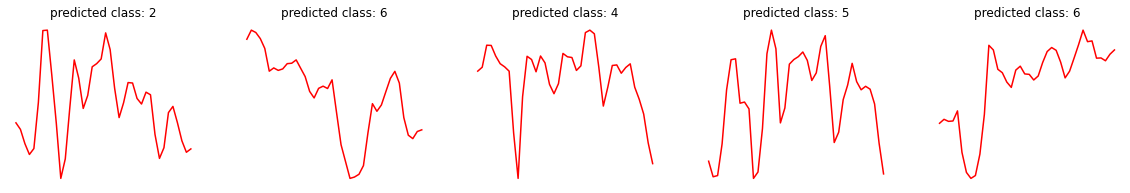

In [7]:
#@title Show some examples from the MNIST 1-D dataset

plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

Text(0.5, 1.0, 'predicted class: 9')

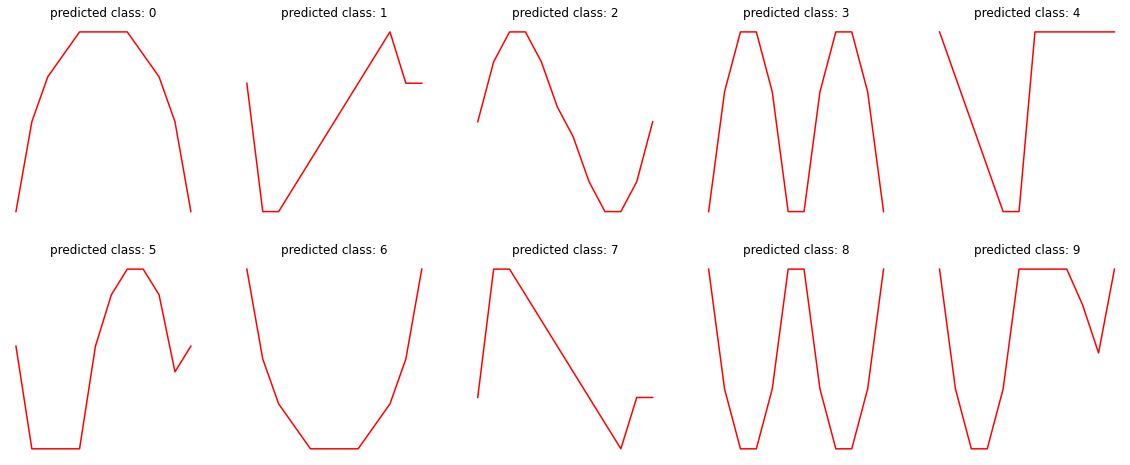

In [8]:
#@title Show the digit templates in the MNIST 1-D dataset 

plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [9]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()

# Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

In [ ]:
##Task1-Question1
weight_decay = 5e-4
model = Sequential()
#Your code starts from here 
model.add(Conv1D(filters=25, kernel_size=5, strides=1, padding='same', activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(weight_decay), bias_regularizer=regularizers.l2(weight_decay), input_shape=(40,1)))
model.add(Conv1D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(weight_decay), bias_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(weight_decay), bias_regularizer=regularizers.l2(weight_decay)))
model.add(Flatten())
model.add(Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(weight_decay), bias_regularizer=regularizers.l2(weight_decay)))

##

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 25)            150       
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________


# Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD) (learning rate = 0.01)

Tensorboard: For recording the training procedure

In [ ]:
##Task1-Question2

#Your code 
model.compile(optimizer='sgd', loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(np.expand_dims(dataset['x'], axis=-1), dataset['y'], epochs=200)
##

Epoch 1/200
125/125 [==============================] - 3s 8ms/step - loss: 2.3131 - accuracy: 0.1380
Epoch 2/200
125/125 [==============================] - 1s 9ms/step - loss: 2.1773 - accuracy: 0.2005
Epoch 3/200
125/125 [==============================] - 1s 7ms/step - loss: 1.9427 - accuracy: 0.2397
Epoch 4/200
125/125 [==============================] - 1s 8ms/step - loss: 1.8057 - accuracy: 0.2895
Epoch 5/200
125/125 [==============================] - 1s 6ms/step - loss: 1.7463 - accuracy: 0.2998
Epoch 6/200
125/125 [==============================] - 1s 4ms/step - loss: 1.6952 - accuracy: 0.3302
Epoch 7/200
125/125 [==============================] - 1s 4ms/step - loss: 1.6384 - accuracy: 0.3545
Epoch 8/200
125/125 [==============================] - 1s 4ms/step - loss: 1.5748 - accuracy: 0.3837
Epoch 9/200
125/125 [==============================] - 1s 4ms/step - loss: 1.5256 - accuracy: 0.4108
Epoch 10/200
125/125 [==============================] - 1s 4ms/step - loss: 1.4904 - accura

In [ ]:
model.save('models/MNIST1D_self.h5')

# Loading the Model

In [10]:
model=load_model('models/MNIST1D_self.h5')

# Plotting the training progress

3a - loss and accuracy curves


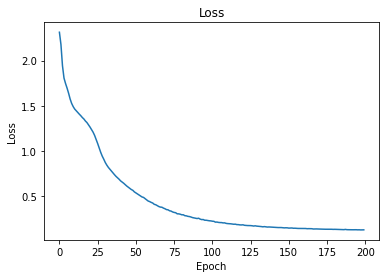

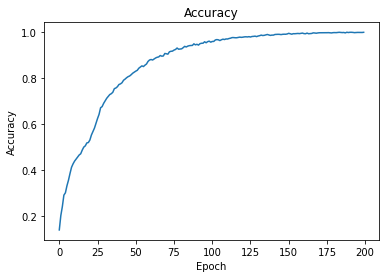

In [ ]:
##Task1-Question3.a

#Your code
# 3a - loss and accuracy curves 
print('3a - loss and accuracy curves')
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


##

In [11]:

#3b - Overall classification accuracy
print('3b - Overall classification accuracy')
test_history = model.evaluate(np.expand_dims(dataset['x_test'], axis=-1), dataset['y_test'])
print("Overall classification accuracy on test set is: %f" % test_history[1])


3b - Overall classification accuracy
32/32 [==============================] - 1s 3ms/step - loss: 0.4519 - accuracy: 0.8980
Overall classification accuracy on test set is: 0.898000


In [12]:
# 3c - Class-wise classfication accuracy 
classwise_accuracy = []
for i in range(10):
  classwise_accuracy.append(model.evaluate(np.expand_dims(dataset['x_test'][np.argwhere(dataset['y_test']==i)].reshape(np.count_nonzero(dataset['y_test']==i),40),axis=-1), dataset['y_test'][dataset['y_test']==i])[1])
for i in range(10):
  print("Classwise classification accuracy for class %d is: %f" % (i, classwise_accuracy[i]))

4/4 [==============================] - 0s 4ms/step - loss: 0.9927 - accuracy: 0.7255
Classwise classification accuracy for class 0 is: 0.980392
Classwise classification accuracy for class 1 is: 0.942308
Classwise classification accuracy for class 2 is: 0.887640
Classwise classification accuracy for class 3 is: 0.971698
Classwise classification accuracy for class 4 is: 0.867925
Classwise classification accuracy for class 5 is: 0.785714
Classwise classification accuracy for class 6 is: 0.969697
Classwise classification accuracy for class 7 is: 0.895833
Classwise classification accuracy for class 8 is: 0.948980
Classwise classification accuracy for class 9 is: 0.725490


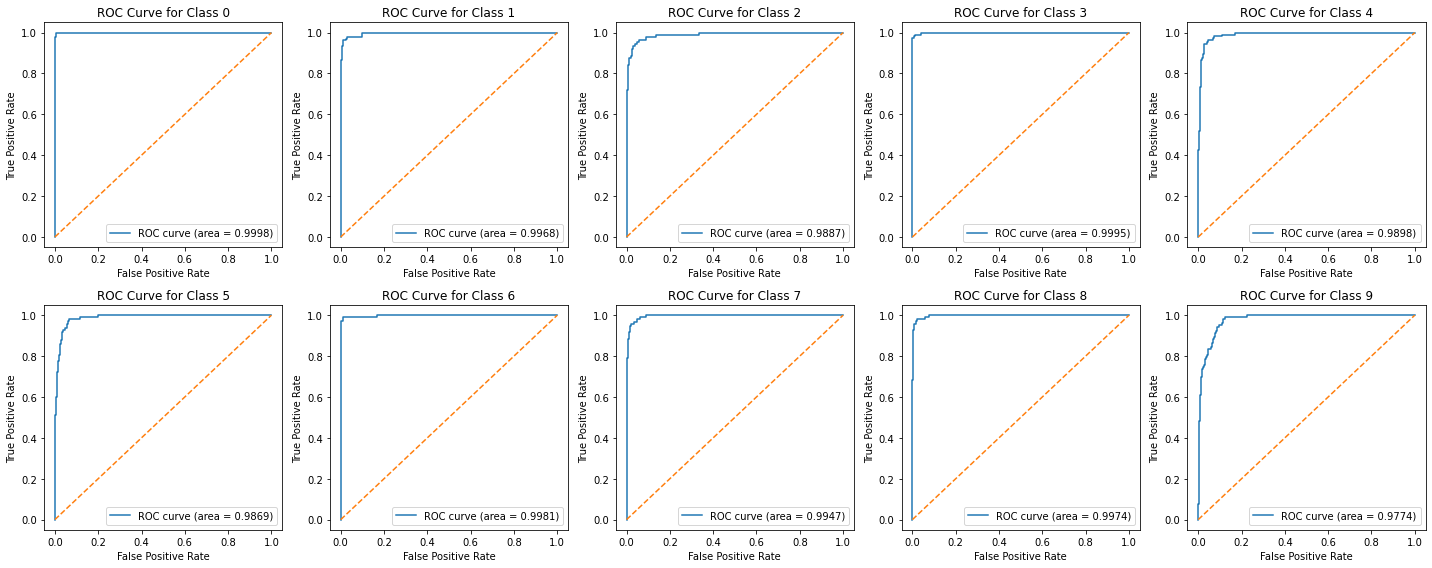

In [15]:
# 3d ROC and AUC curves 
y_onehot = np.zeros((dataset['y_test'].shape[0], 10))
y_onehot[np.arange(dataset['y_test'].shape[0]),dataset['y_test']] = 1
y_pred = model.predict(np.expand_dims(dataset['x_test'], axis=-1))

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(20,8))
for i in range(10):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_onehot[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.subplot(2,5,i+1)
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f)' % roc_auc[i])
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve for Class %d" % i)
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("The AOC for each class (as specified on the plot legends) are:")
roc_auc

The AOC for each class (as specified on the plot legends) are:


{0: 0.9997925673610201,
 1: 0.9967698317307693,
 2: 0.9887270439941293,
 3: 0.9994618209446625,
 4: 0.9897534928875944,
 5: 0.9869337979094077,
 6: 0.9980829381495308,
 7: 0.9946879609144542,
 8: 0.9974320104982126,
 9: 0.9773680073365649}

Text(0.5, 1.0, 'Normalized Confusion Matrix')

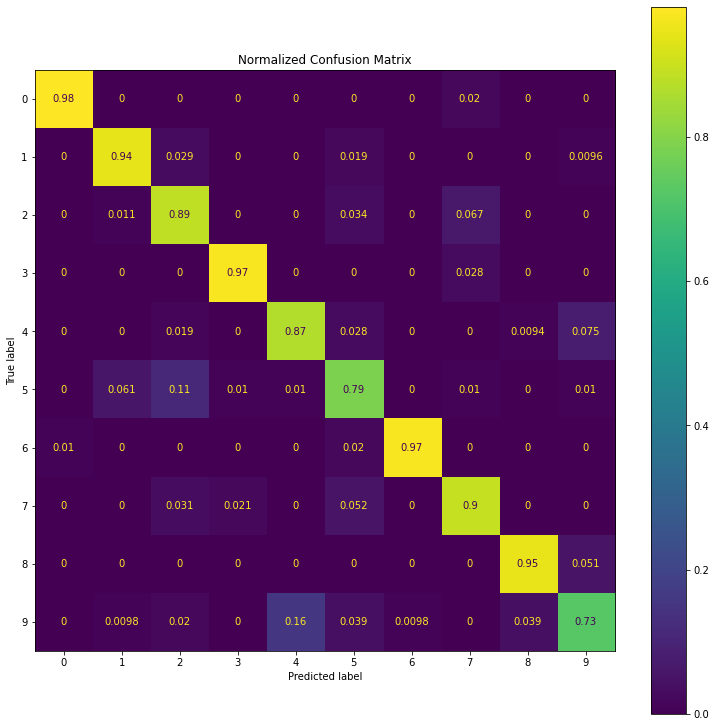

In [16]:
# 3e Normalized confusion matrix
y_pred_labels=np.argmax(y_pred,axis=1)
fig, ax = plt.subplots(figsize=(13,13))
disp = metrics.ConfusionMatrixDisplay.from_predictions(dataset['y_test'], y_pred_labels, normalize='true',ax=ax)
ax.set_title("Normalized Confusion Matrix")


In [17]:
# 3f Precision, Recall, and F-1 score
precision, recall, f1, _ = metrics.precision_recall_fscore_support(dataset['y_test'], y_pred_labels, average='micro')
print("Precision, Recall, and F-1 score for whole set: ")
print("  Precision: %f" % precision)
print("  Recall: %f" % recall)
print("  F-1: %f" % f1)

for i in range(10):
  precision, recall, f1, _ = metrics.precision_recall_fscore_support(dataset['y_test'], y_pred_labels, labels=[i], average = 'micro')
  print("Precision, Recall, and F-1 score for class %d: " %i)
  print("  Precision: %f" % precision)
  print("  Recall: %f" % recall)
  print("  F-1: %f" % f1)


Precision, Recall, and F-1 score for whole set: 
  Precision: 0.898000
  Recall: 0.898000
  F-1: 0.898000
Precision, Recall, and F-1 score for class 0: 
  Precision: 0.990099
  Recall: 0.980392
  F-1: 0.985222
Precision, Recall, and F-1 score for class 1: 
  Precision: 0.924528
  Recall: 0.942308
  F-1: 0.933333
Precision, Recall, and F-1 score for class 2: 
  Precision: 0.790000
  Recall: 0.887640
  F-1: 0.835979
Precision, Recall, and F-1 score for class 3: 
  Precision: 0.971698
  Recall: 0.971698
  F-1: 0.971698
Precision, Recall, and F-1 score for class 4: 
  Precision: 0.844037
  Recall: 0.867925
  F-1: 0.855814
Precision, Recall, and F-1 score for class 5: 
  Precision: 0.802083
  Recall: 0.785714
  F-1: 0.793814
Precision, Recall, and F-1 score for class 6: 
  Precision: 0.989691
  Recall: 0.969697
  F-1: 0.979592
Precision, Recall, and F-1 score for class 7: 
  Precision: 0.877551
  Recall: 0.895833
  F-1: 0.886598
Precision, Recall, and F-1 score for class 8: 
  Precision: 0.

# Visualization

In [13]:
x_test = dataset['x_test']
y_test = dataset['y_test']

## Success Cases

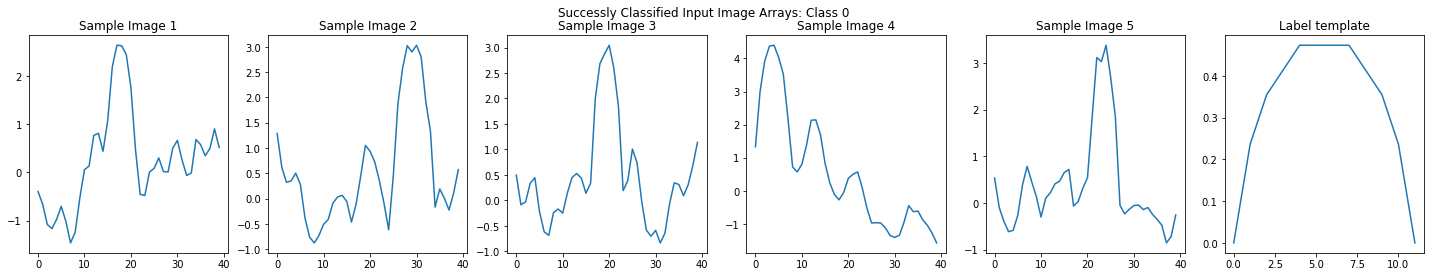

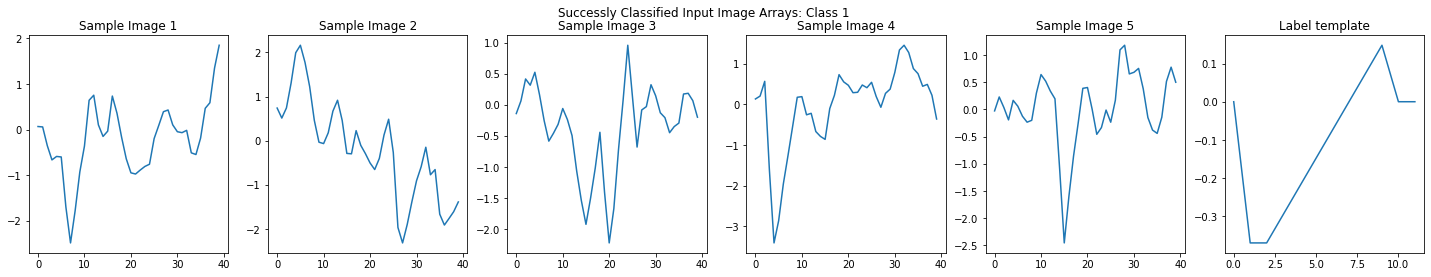

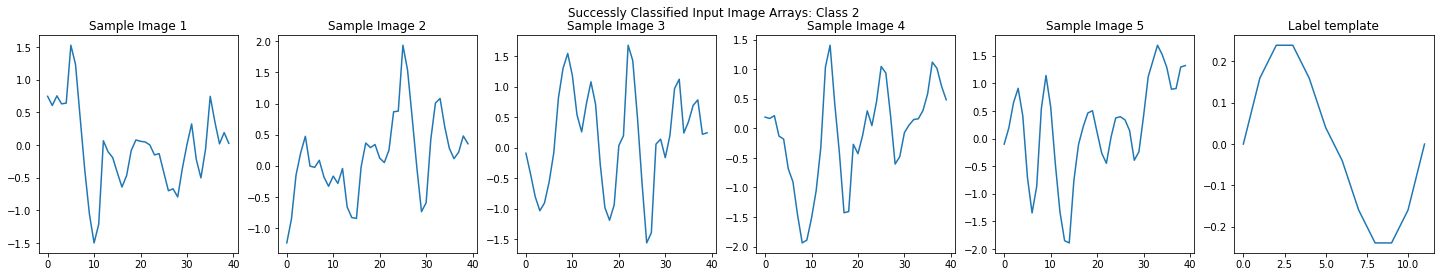

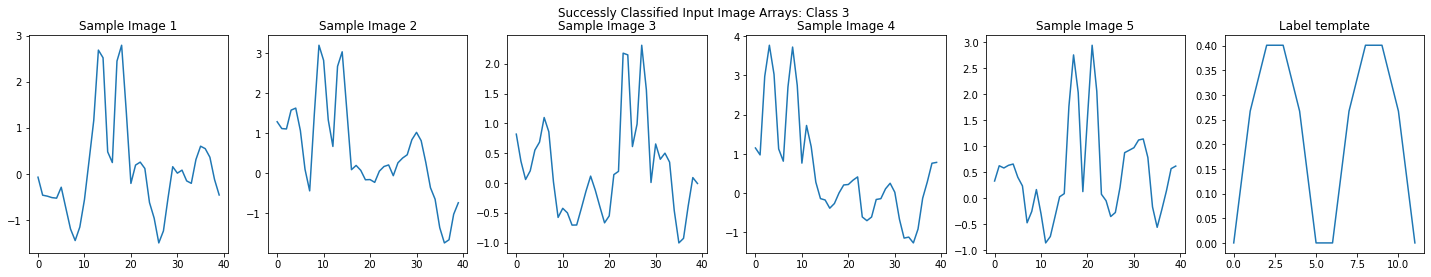

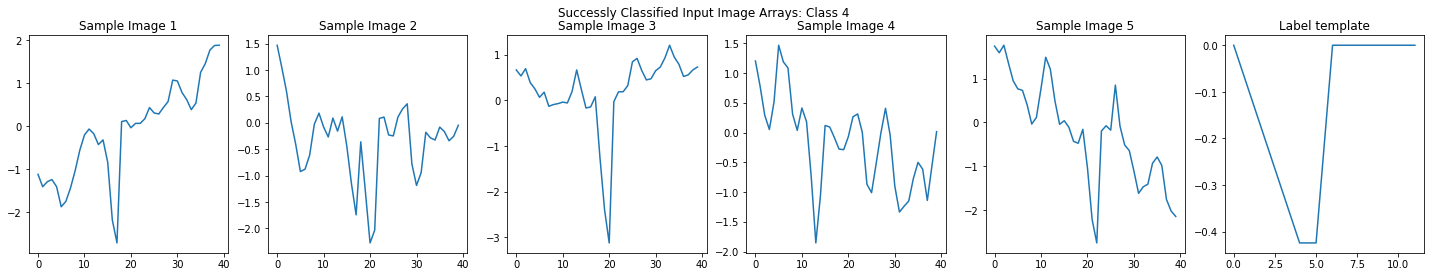

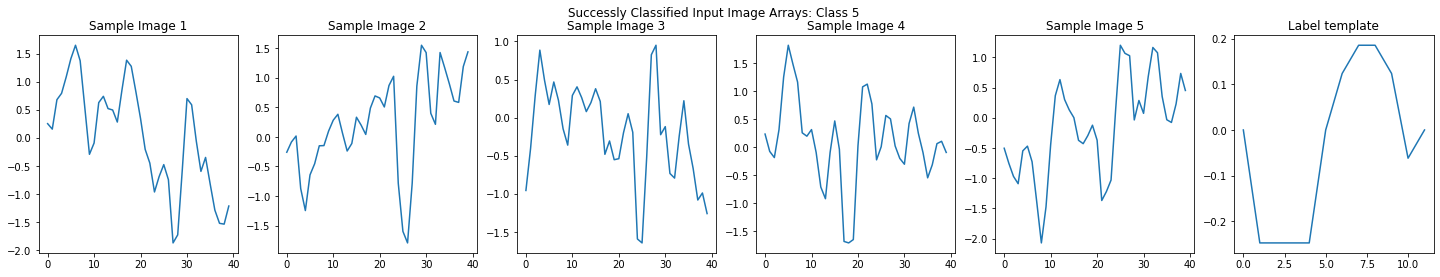

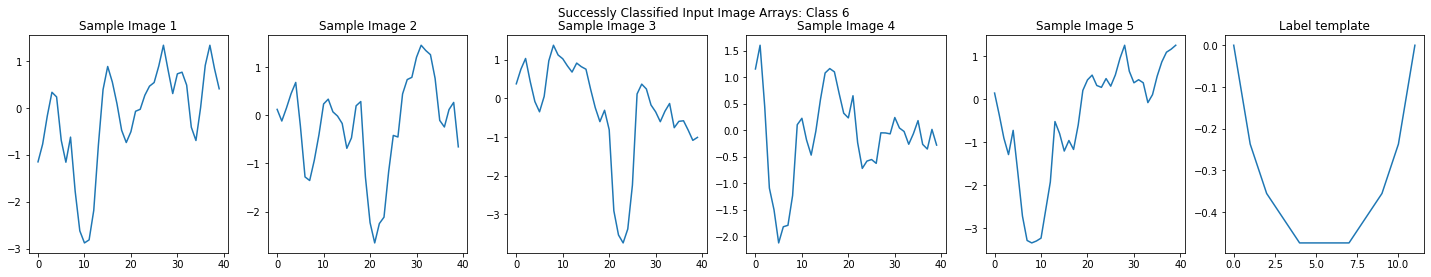

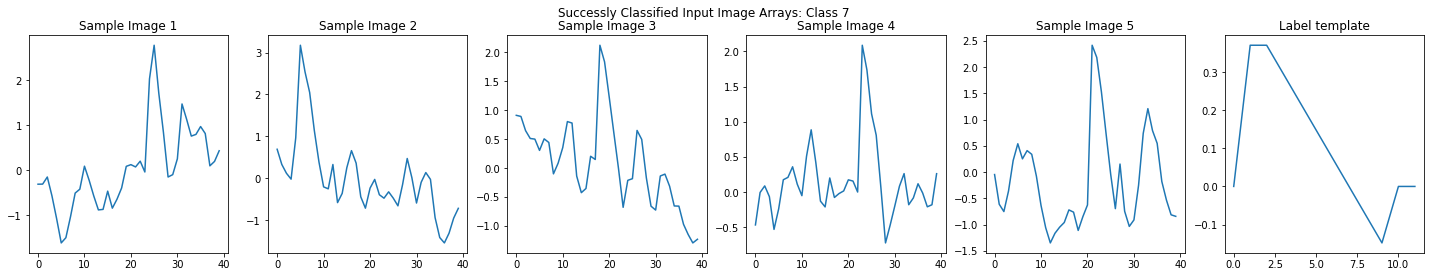

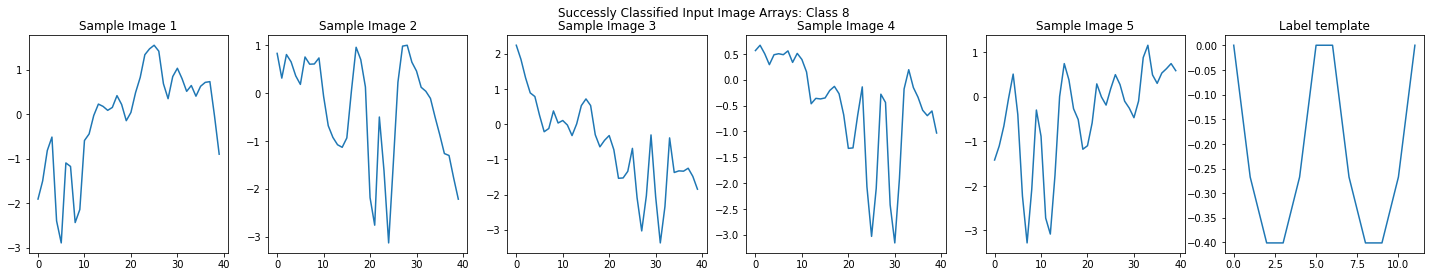

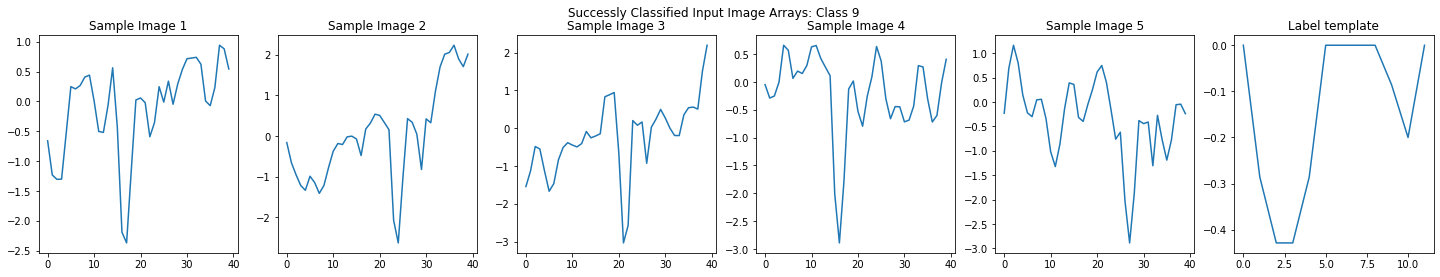

In [22]:
# 4. Code to show success/failure cases
# Success Cases
plotted_index_success = {}
for i in range(10):
  plotted_index_success[i] = []

for i in range(10):
  plt.figure(figsize=(25,4))
  plt.suptitle('Successly Classified Input Image Arrays: Class %d' % i)
  j = 0
  while(j<5):
    index = int(np.floor(np.random.rand()*1000))
    input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
    predicted = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())
    label = y_test[index]
    if (label == predicted) and (label == i):
      if (index not in plotted_index_success[i]):
        plt.subplot(1,6,j+1)
        plt.plot(input[0], label = 'Label=Predicted=%d' % label)
        plt.title('Sample Image %d' % (j+1))
        plotted_index_success[i].append(index)
        #plt.legend(loc='lower right')
        j+=1
  plt.subplot(1,6,6)
  plt.plot(dataset['templates']['x'][i])
  plt.title('Label template')
  #plt.tight_layout()
  plt.show()

## Failure Cases

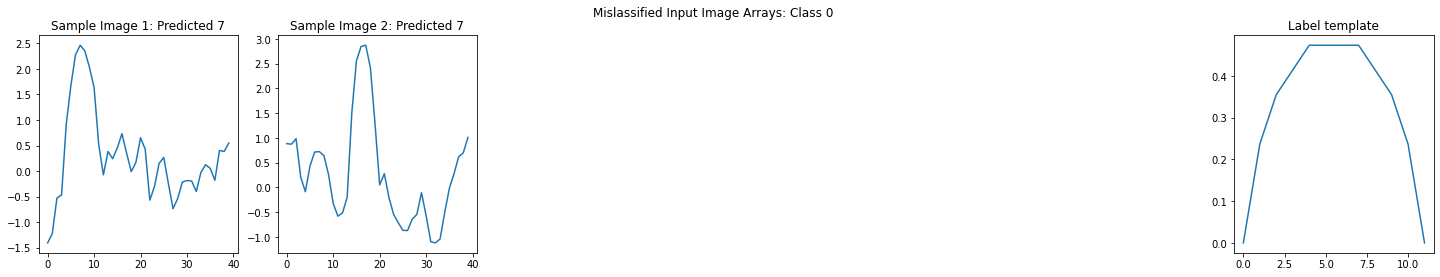

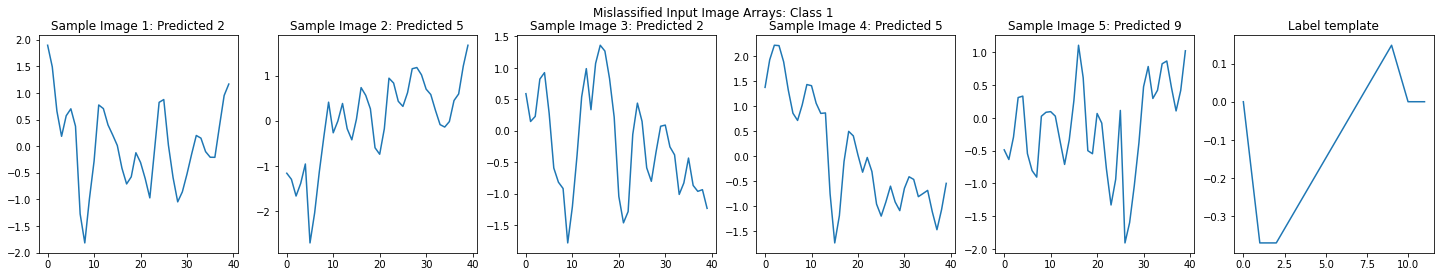

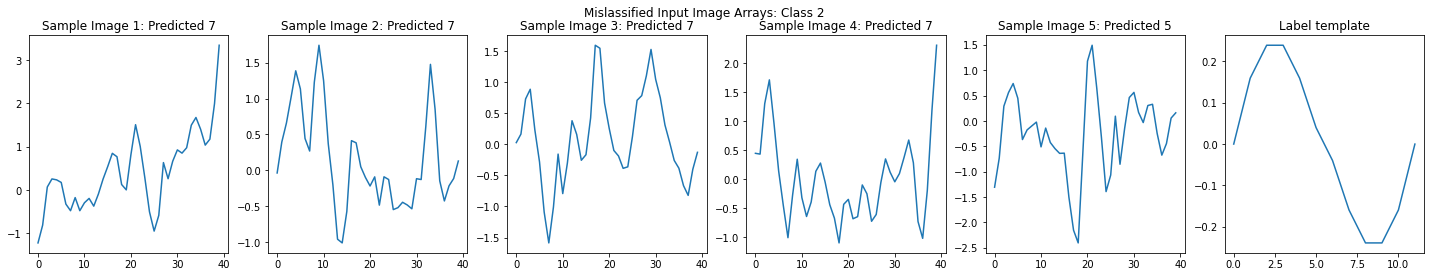

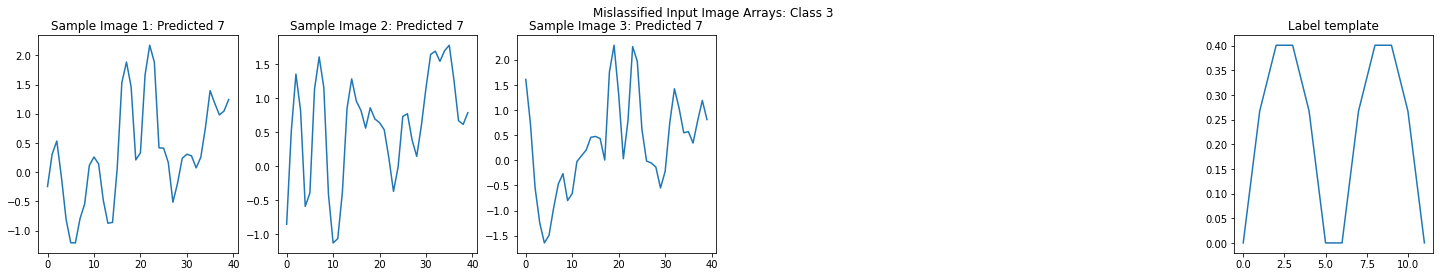

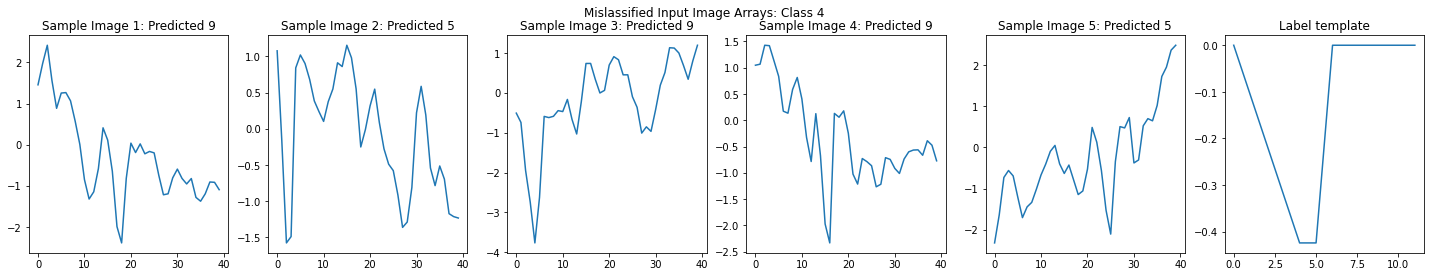

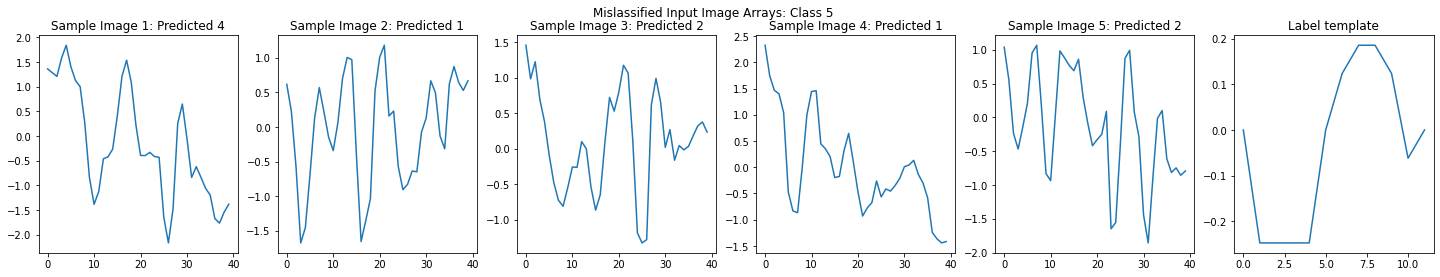

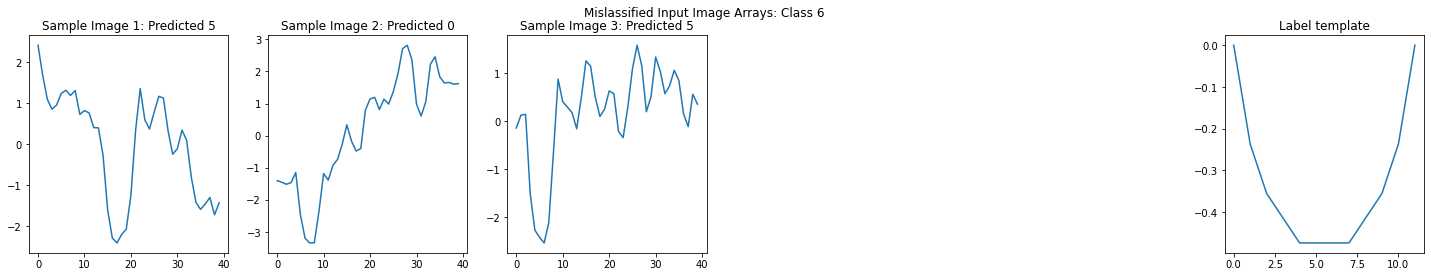

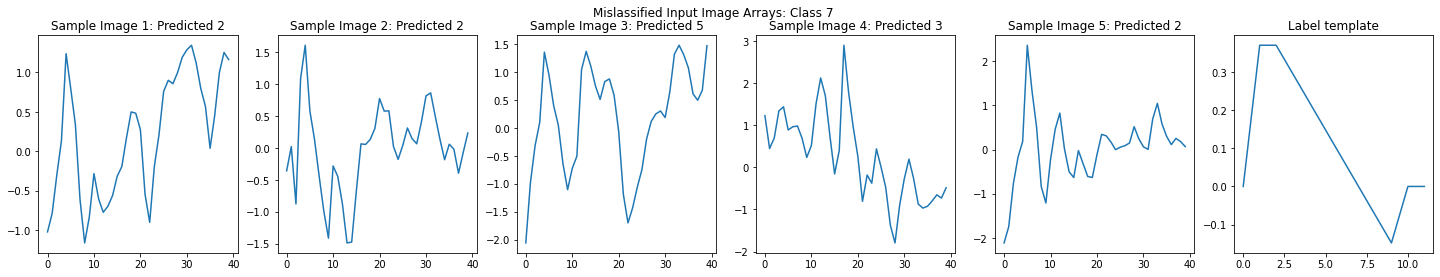

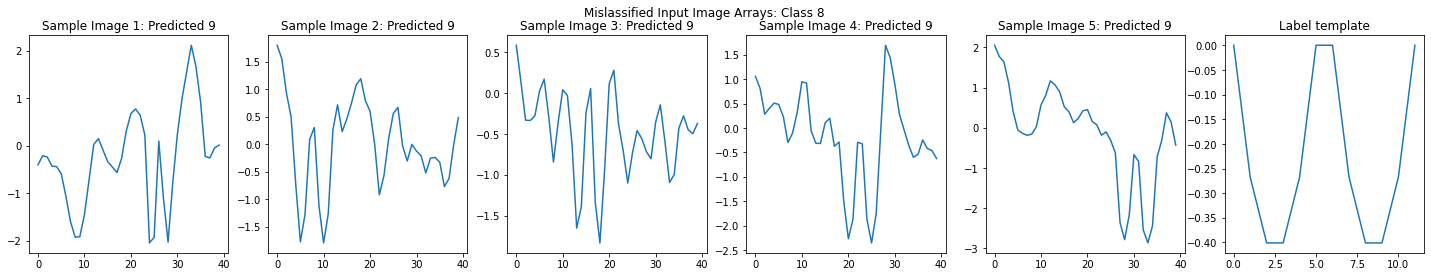

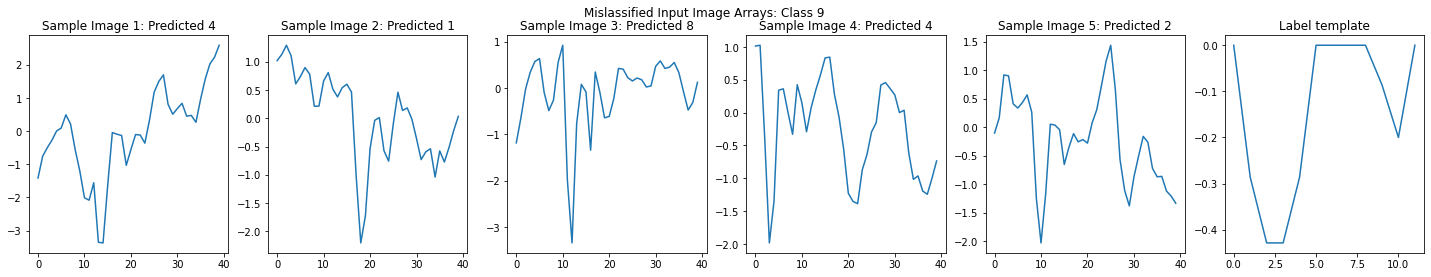

In [14]:
# Note that the image differ from the images used in the report since this was later ran again. 

# Find indices for all failed cases
Image_Library={}
plotted_index_failed = {}
for i in range(10):
  Image_Library[i] = []
  plotted_index_failed[i] = []
for i in range (1000):
  input = np.expand_dims(np.expand_dims(x_test[i], axis=0), axis=-1)
  label = y_test[i]
  predicted = np.argmax(model(np.expand_dims(np.expand_dims(x_test[i], axis=0), axis=-1)).numpy())
  if (label != predicted):
    Image_Library[label].append(i)
  
# Plot these cases
for i in range(10):
  plt.figure(figsize=(25,4))
  plt.suptitle('Mislassified Input Image Arrays: Class %d' % i)
  num_images = min(5,len(Image_Library[i]))
  numbers = np.random.choice(len(Image_Library[i]), size=num_images, replace=False)
  for j in range(num_images):
    index = Image_Library[i][numbers[j]]
    input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
    predicted = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())
    plotted_index_failed[i].append(index)
    label = y_test[index]
    plt.subplot(1,6,j+1)
    plt.plot(input[0], label = 'Label=Predicted=%d' % label)
    plt.title('Sample Image %d: Predicted %d' % (j+1, predicted))
    #plt.legend(loc='lower right')
  plt.subplot(1,6,6)
  plt.plot(dataset['templates']['x'][i])
  plt.title('Label template')
  #plt.tight_layout()
  plt.show()

## Visualizing the Templates

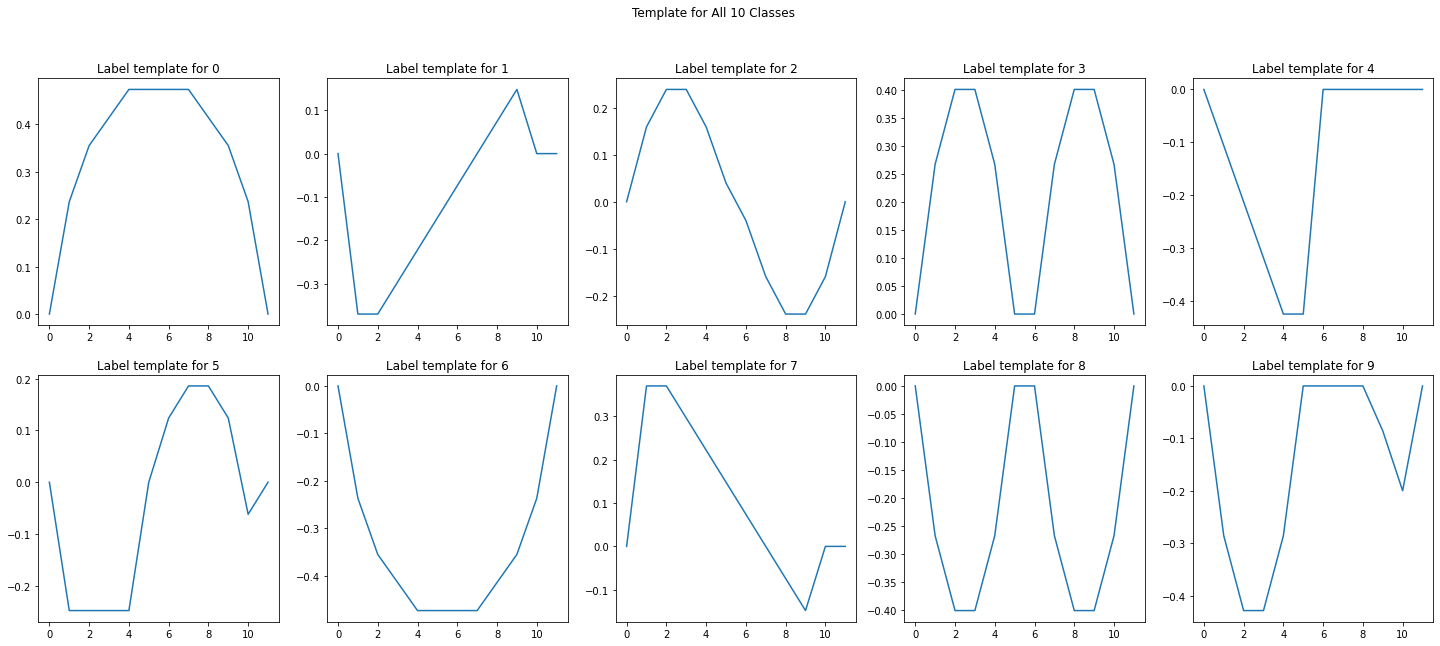

In [16]:
plt.figure(figsize=(25,10))
plt.suptitle("Template for All 10 Classes")
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.plot(dataset['templates']['x'][i])
  plt.title('Label template for %d' % i)
  #plt.tight_layout()
plt.show()

# Explanation

In [22]:
from xai_utils import *

Take a test sample

In [20]:
x_test = dataset['x_test']
y_test = dataset['y_test']

## SISE (Semantic Input Sampling for Explanation)

Correct digit: 5
Predicted digit: 5
Confidence score for the correct label: 0.9394269


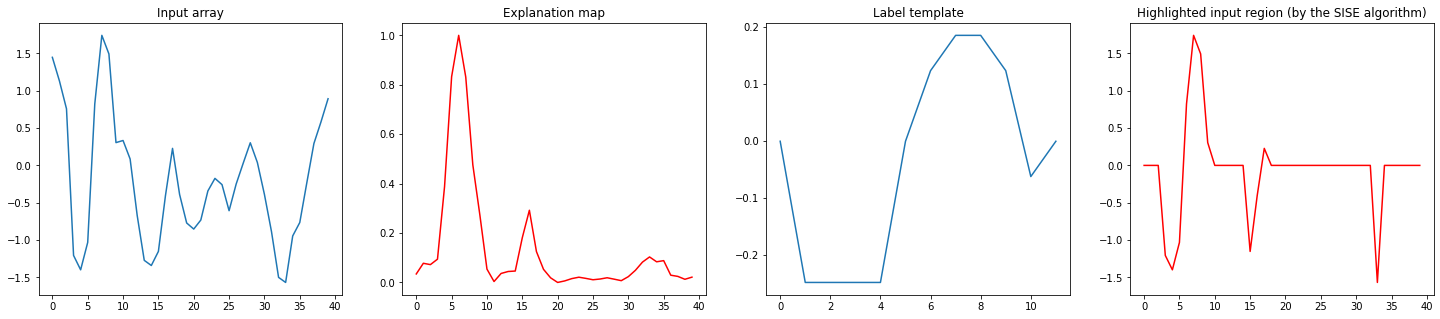

In [26]:
index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(input).numpy()[0,label]))

explanation = SISE(input, model, label, [['conv1d_2']], grad_thr=0.)
threshold = np.sort(explanation[:,0])[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the SISE algorithm)')
plt.show()


## Integrated Gradient

In [24]:
def get_gradients(input, model, pred_index):
  image = tensorflow.convert_to_tensor(input)
  with tensorflow.GradientTape() as tape:
    tape.watch(image)
    prediction=model(image)
    gradient = tape.gradient(prediction[0][pred_index],image)
  return gradient

def Integrated_Gradients(input, model, label, num_steps):
  baseline = np.zeros(input.shape)
  grads = np.zeros((40,1))
  for i in range(num_steps):
    difference = (i+1/num_steps) * (input - baseline)
    grads = grads + get_gradients(difference, model, label).numpy()[0] / num_steps
  return input[0]*grads

Correct digit: 6
Predicted digit: 6
Confidence score for the correct label: 0.99785066


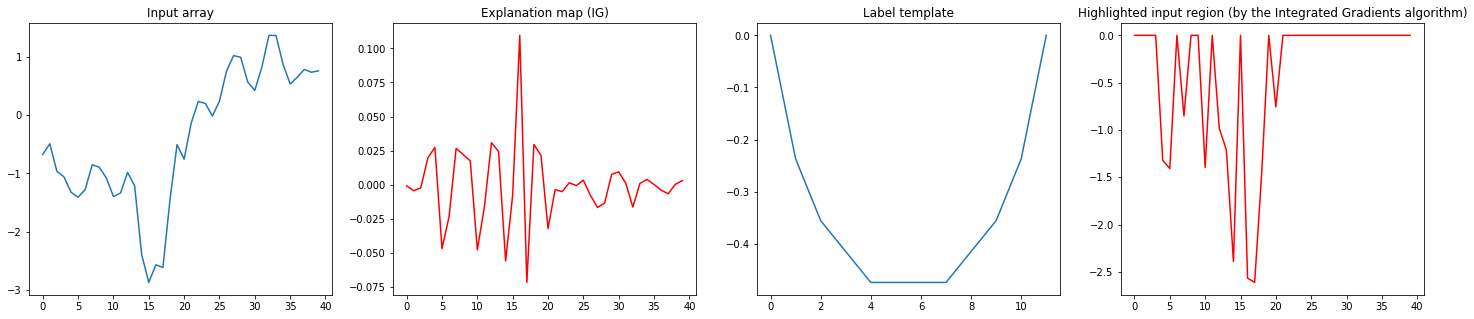

In [25]:
index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

explanation = Integrated_Gradients(input, model, label, 100)
threshold = np.sort(np.absolute(explanation[:,0]))[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map (IG)')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0]*(np.absolute(explanation)>threshold)), 'r')
plt.title('Highlighted input region (by the Integrated Gradients algorithm)')
plt.show()

explanation = SISE(input, model, label, [['conv1d_2']], grad_thr=0.)
threshold = np.sort(explanation[:,0])[-12]

plt.show()


## Examples of Visualization

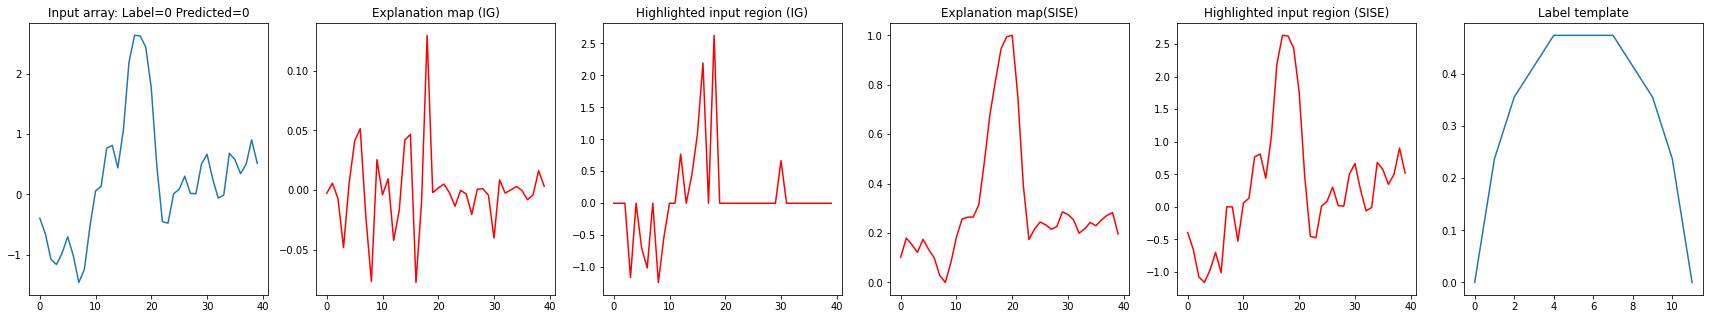

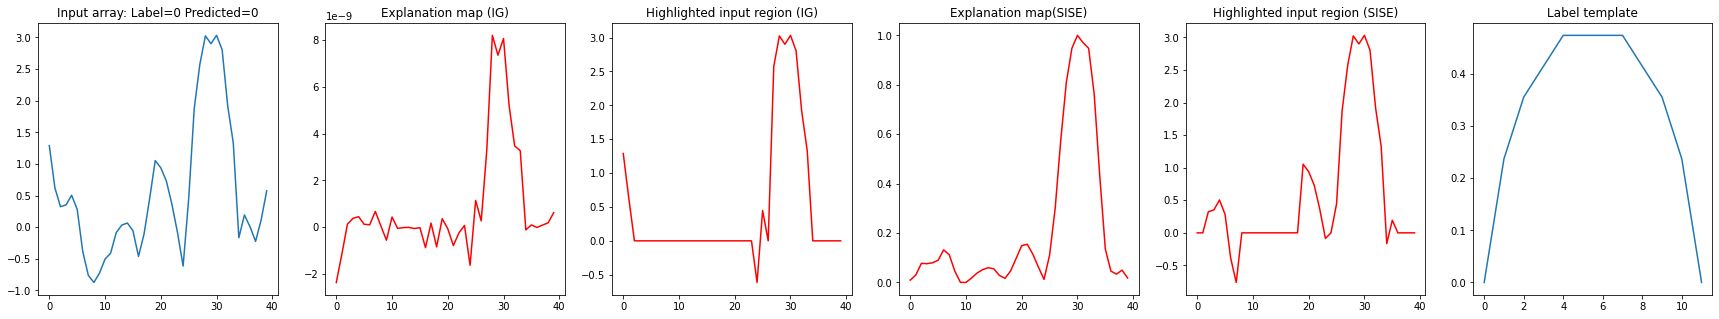

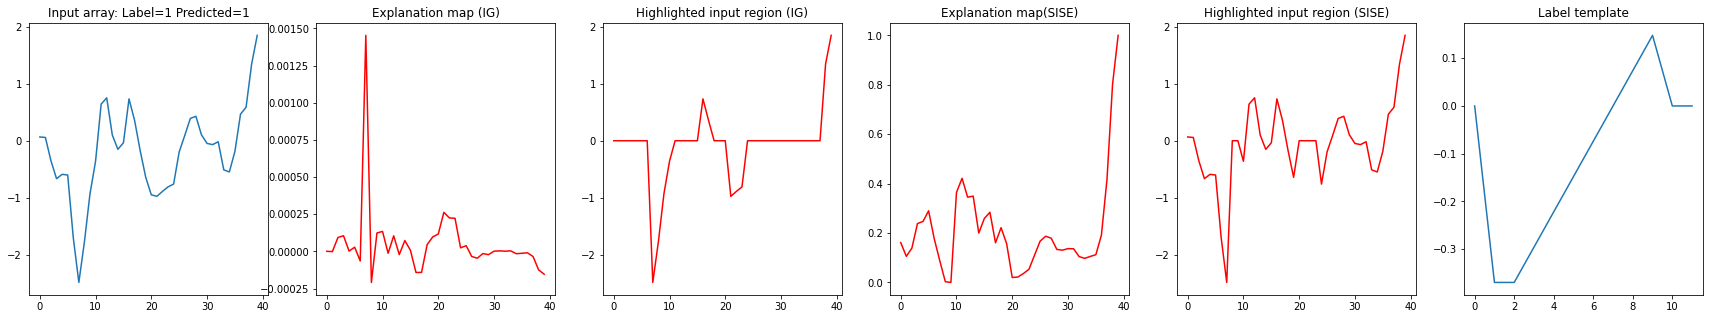

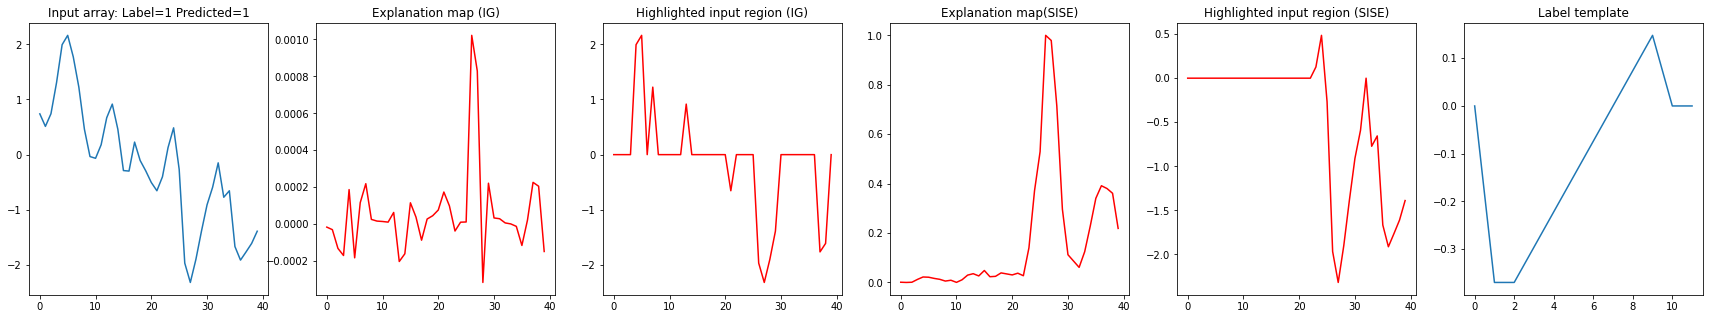

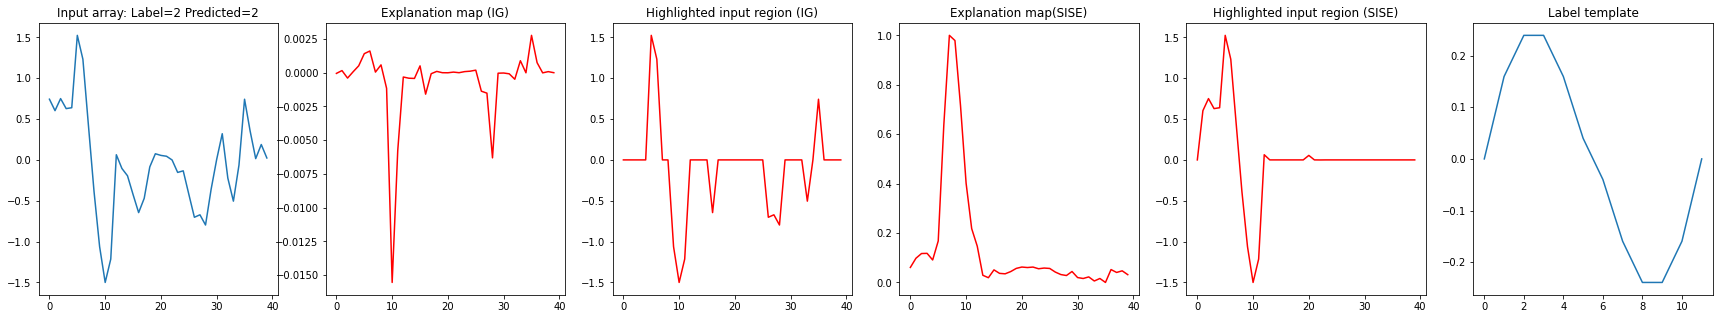

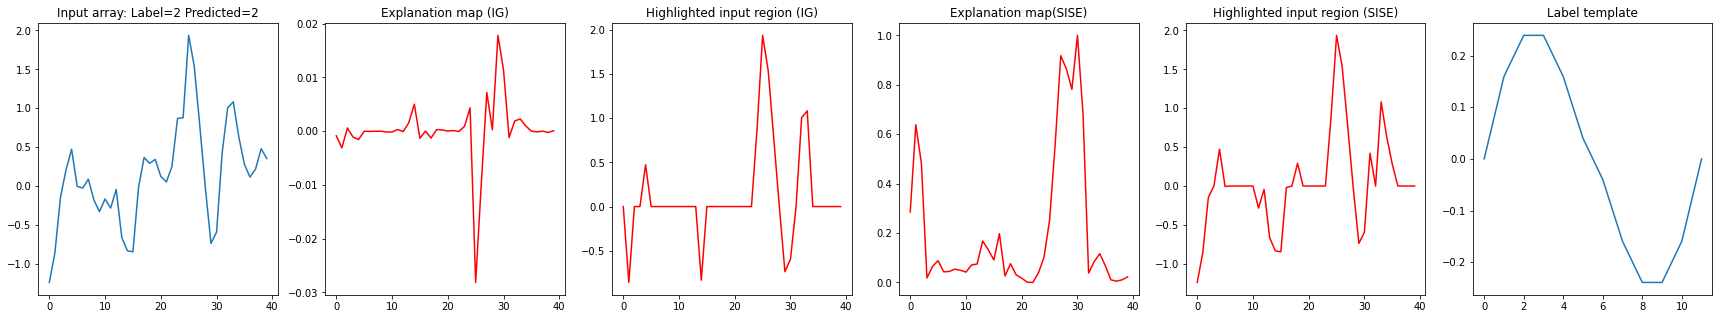

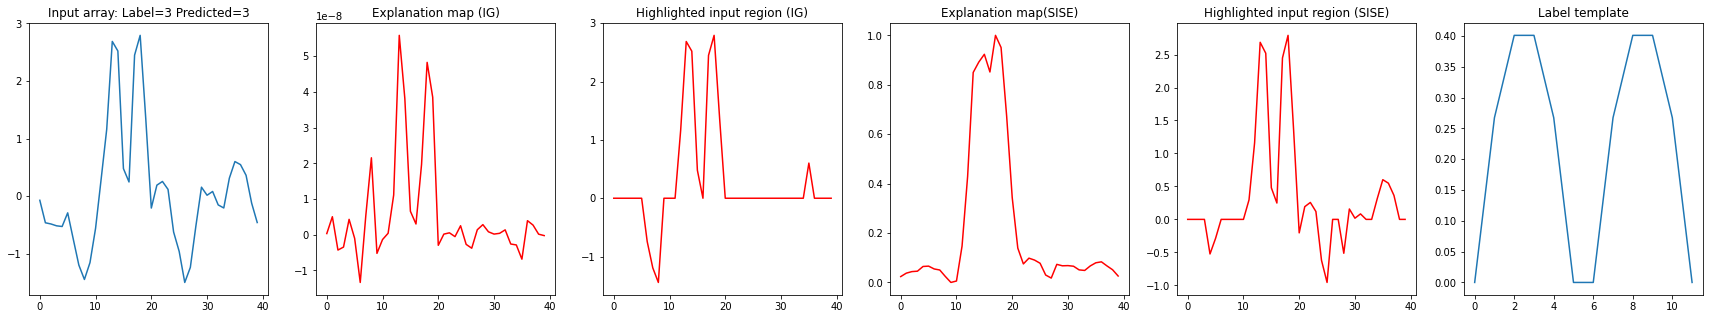

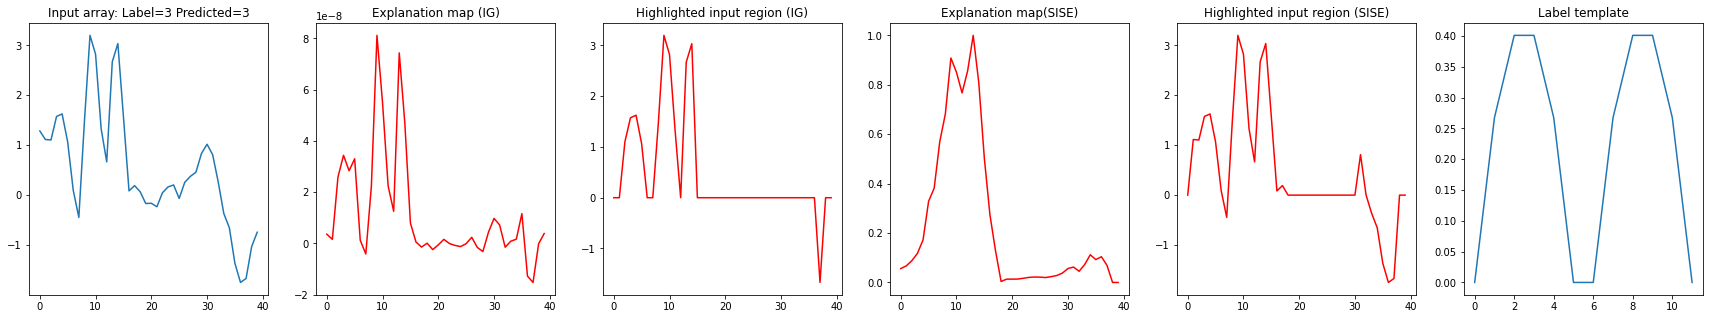

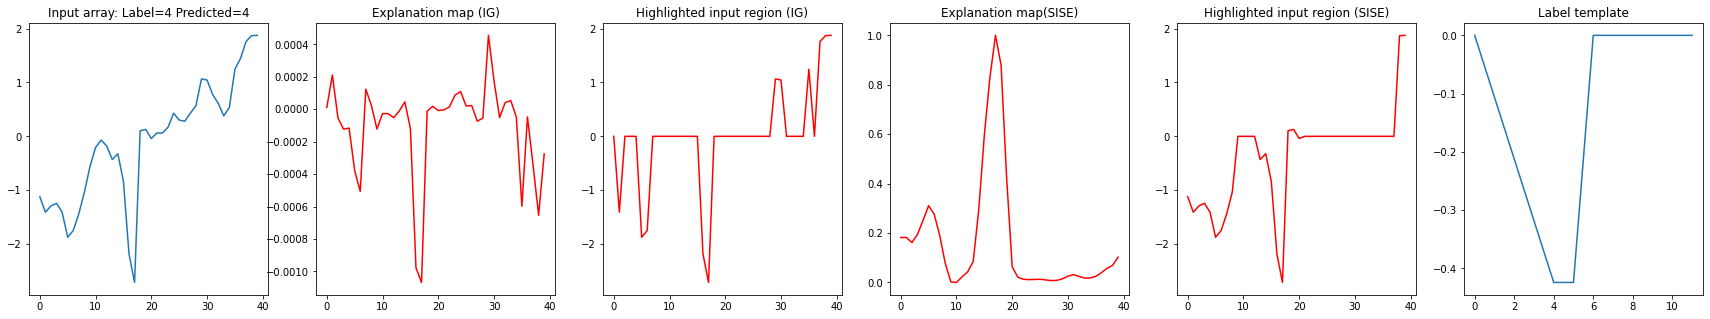

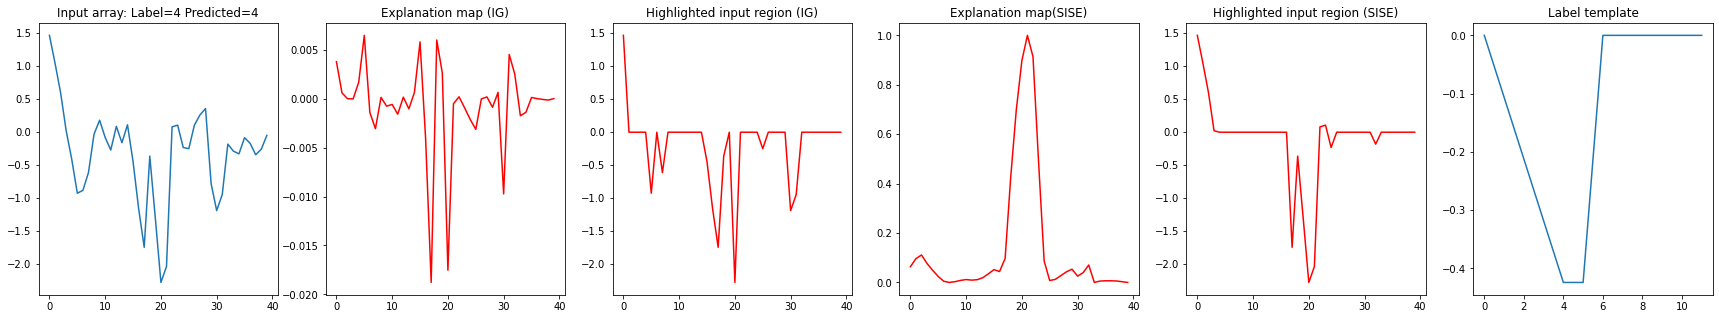

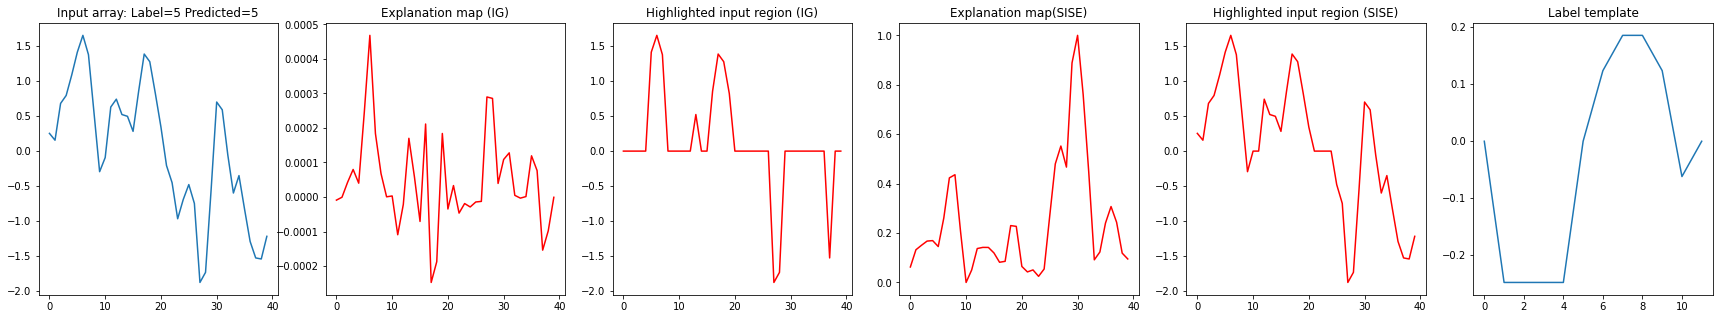

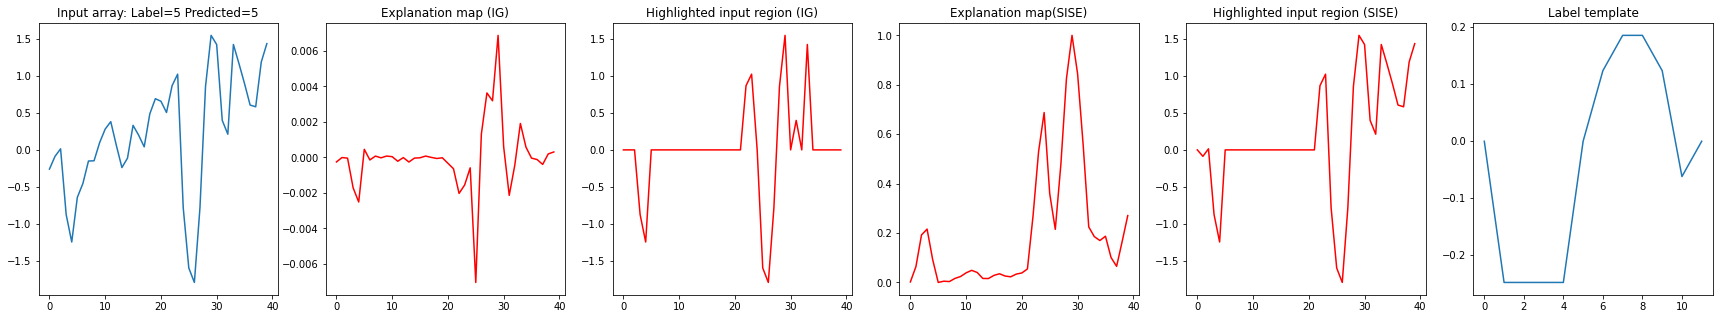

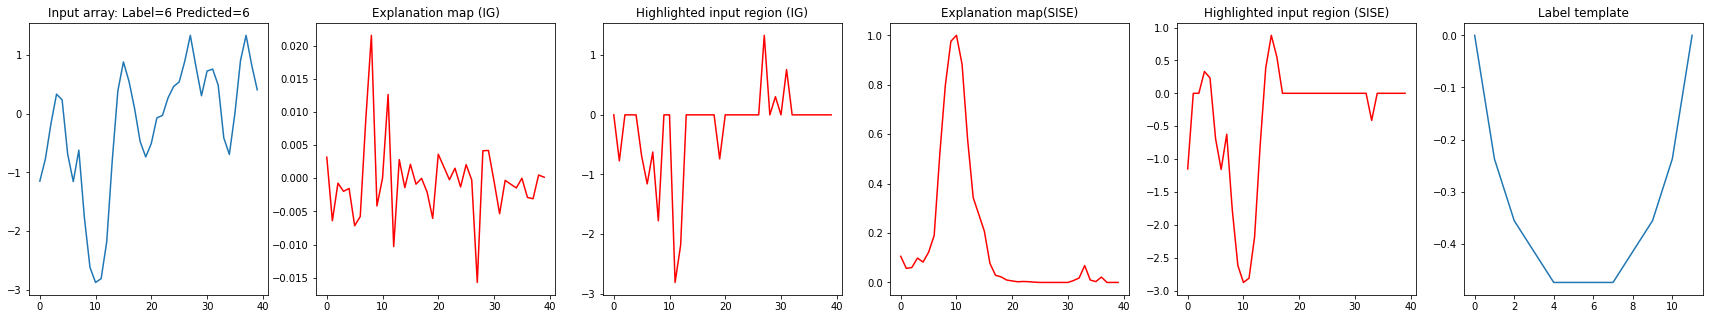

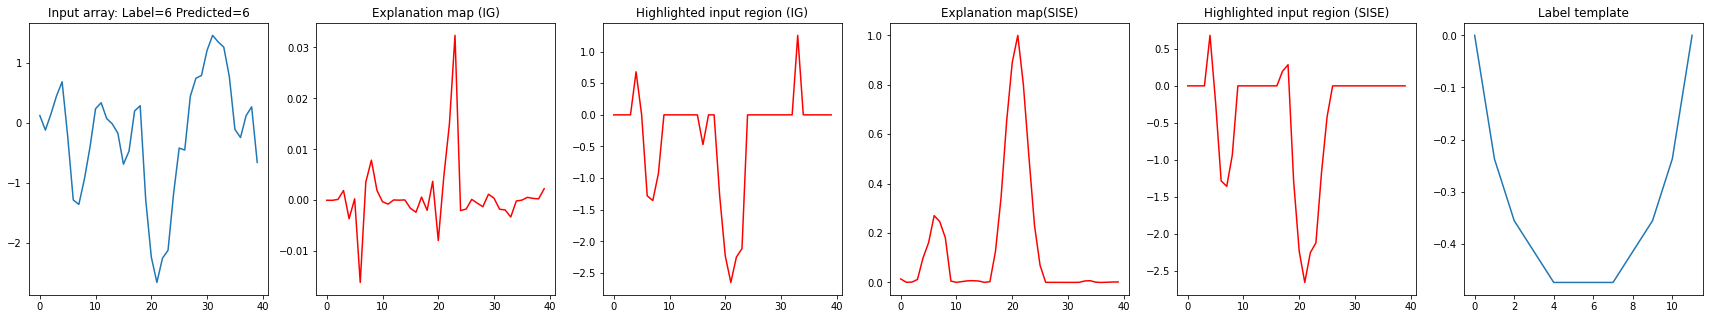

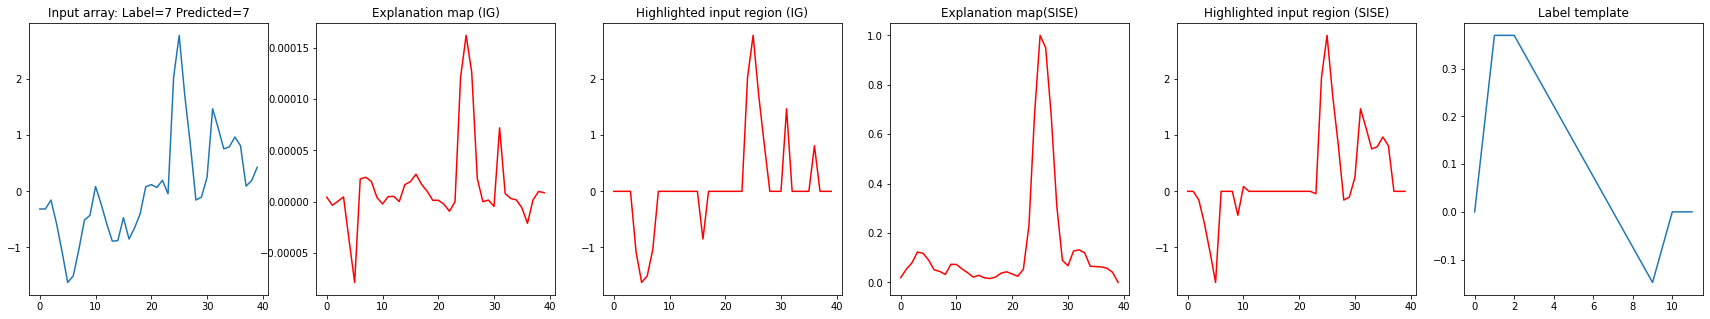

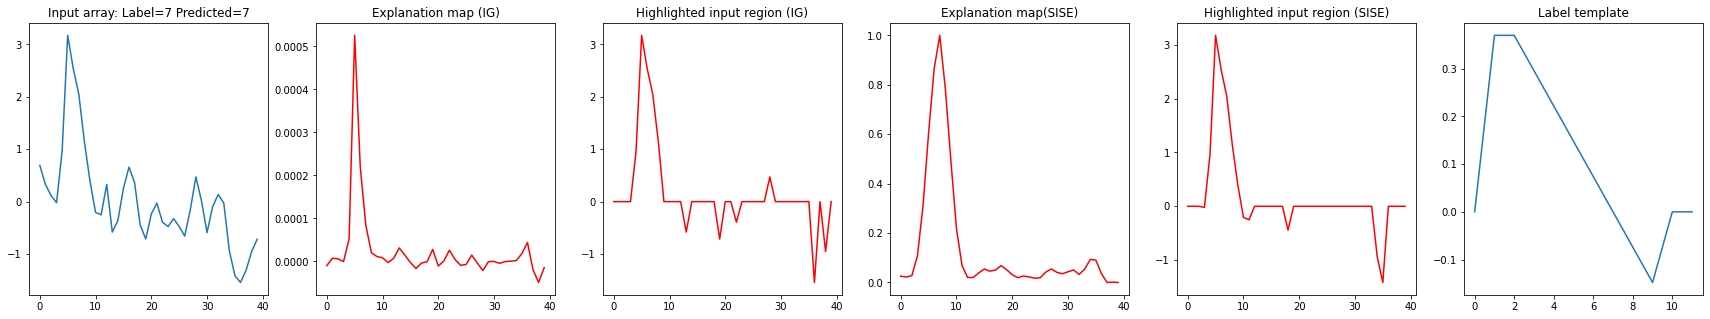

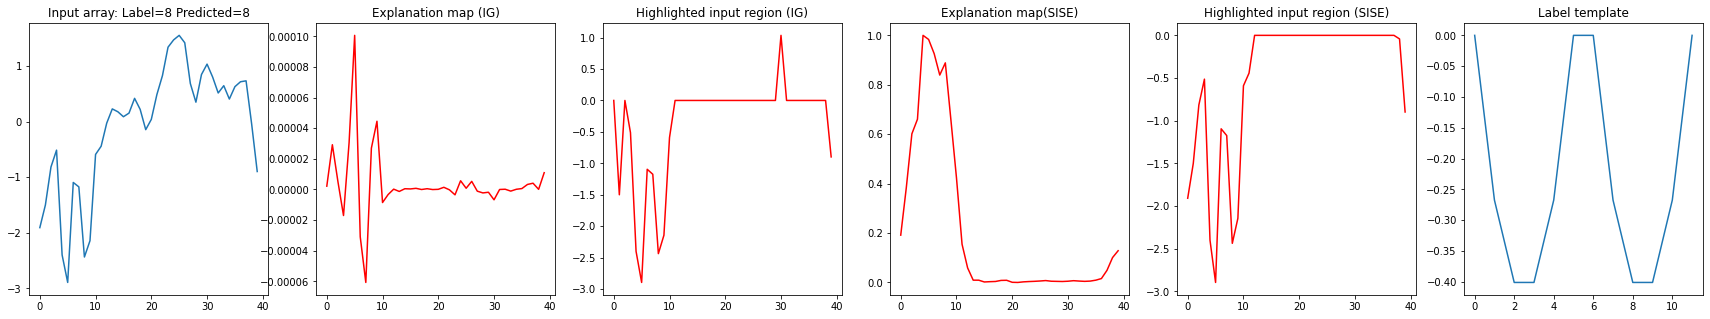

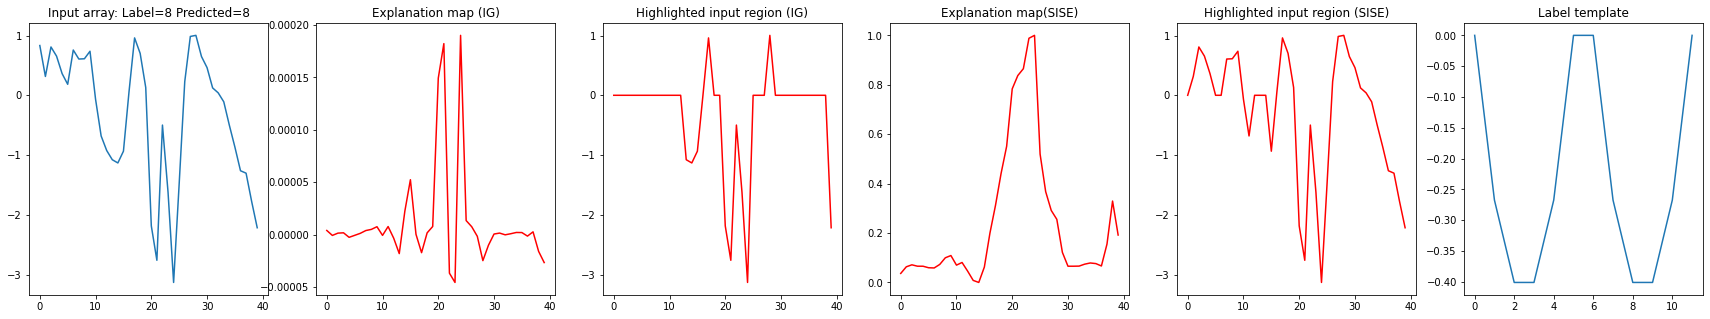

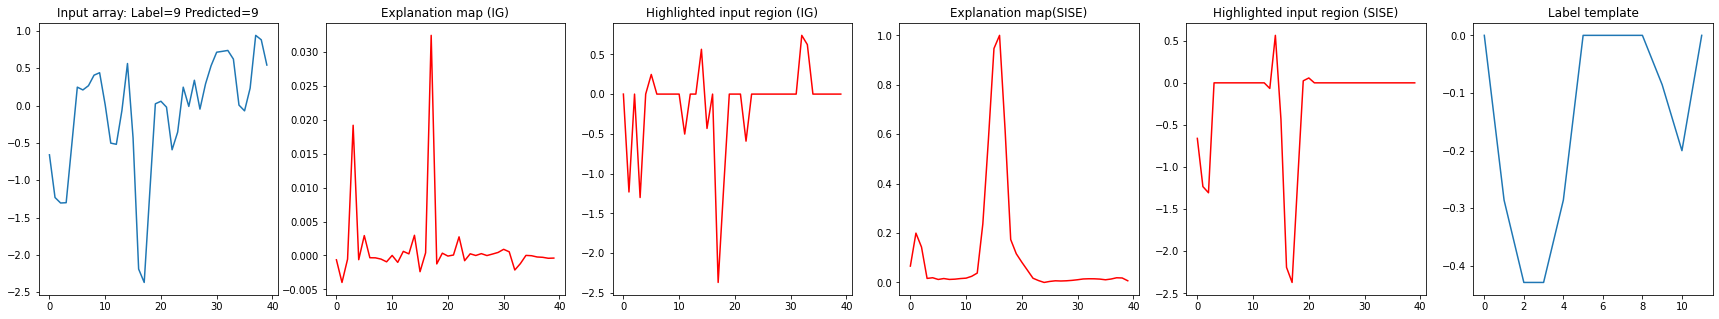

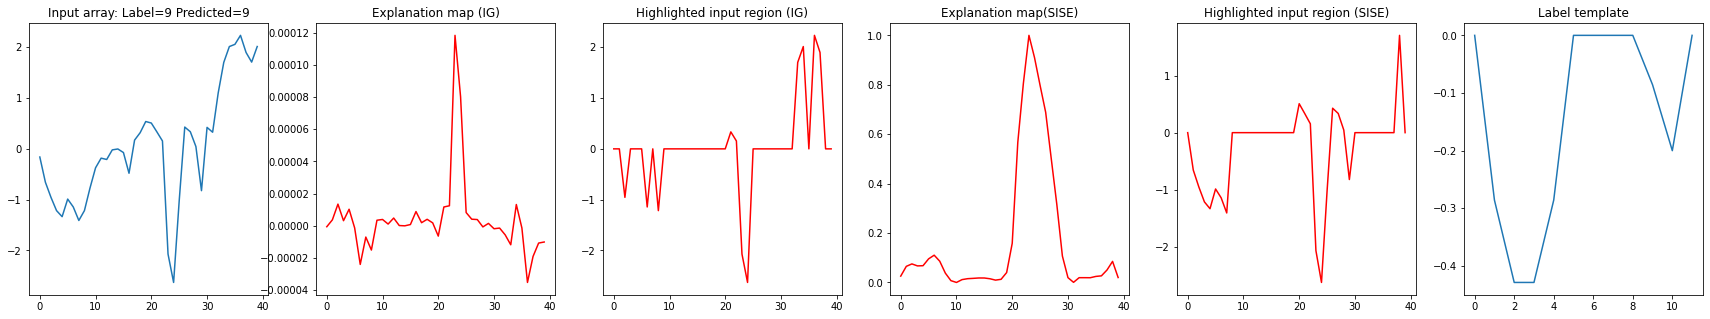

In [38]:
for i in range(10):
  for j in range(2):
    index = plotted_index_success[i][j]
    input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
    label = y_test[index]
    predicted = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)))

    num_plots = 6
    plt.figure(figsize=(5*num_plots,5))
    plt.subplot(1,num_plots,1)
    plt.plot(input[0])
    plt.title('Input array: Label=%d Predicted=%d'%(label,predicted))
    explanation_IG = Integrated_Gradients(input, model, label, 100)
    threshold_IG = np.sort(np.absolute(explanation_IG[:,0]))[-12]

    plt.subplot(1,num_plots,2)
    plt.plot(explanation_IG, 'r')
    plt.title('Explanation map (IG)')

    plt.subplot(1,num_plots,3)
    plt.plot((input[0]*(np.absolute(explanation_IG)>threshold_IG)), 'r')
    plt.title('Highlighted input region (IG)')


    explanation_SISE = SISE(input, model, label, [['conv1d_2']], grad_thr=0.)
    threshold_SISE = np.sort(explanation[:,0])[-12]
    
    plt.subplot(1,num_plots,4)
    plt.plot(explanation_SISE, 'r')
    plt.title('Explanation map(SISE)')

    plt.subplot(1,num_plots,5)
    plt.plot((input[0]*(explanation_SISE>threshold_SISE)), 'r')
    plt.title('Highlighted input region (SISE)')

    plt.subplot(1,num_plots,6)
    plt.plot(dataset['templates']['x'][label])
    plt.title('Label template')
    plt.show()

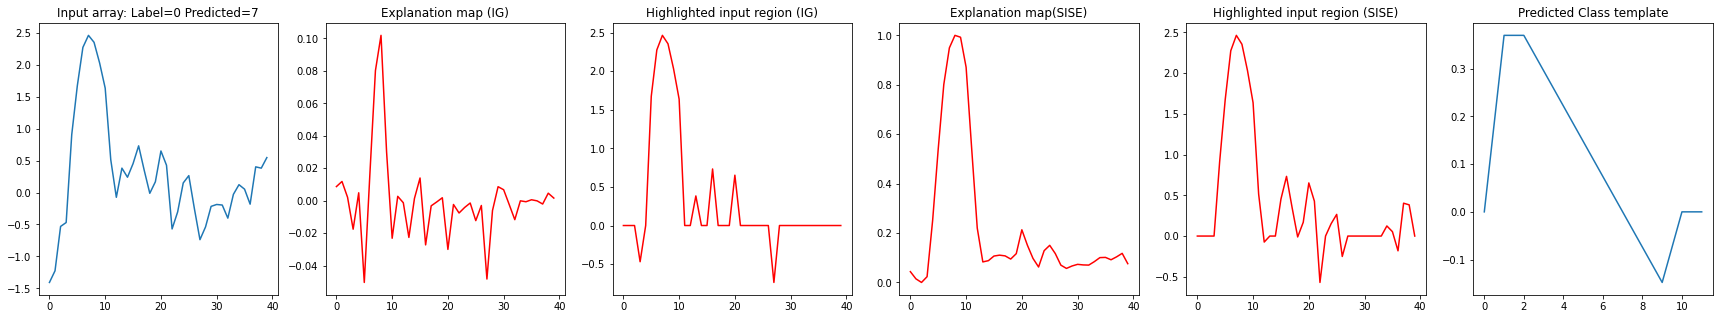

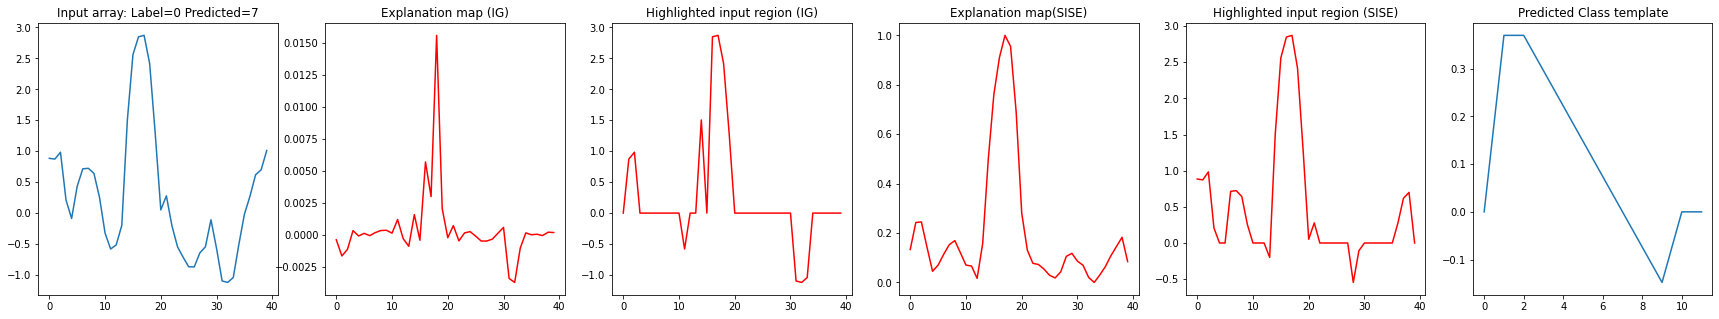

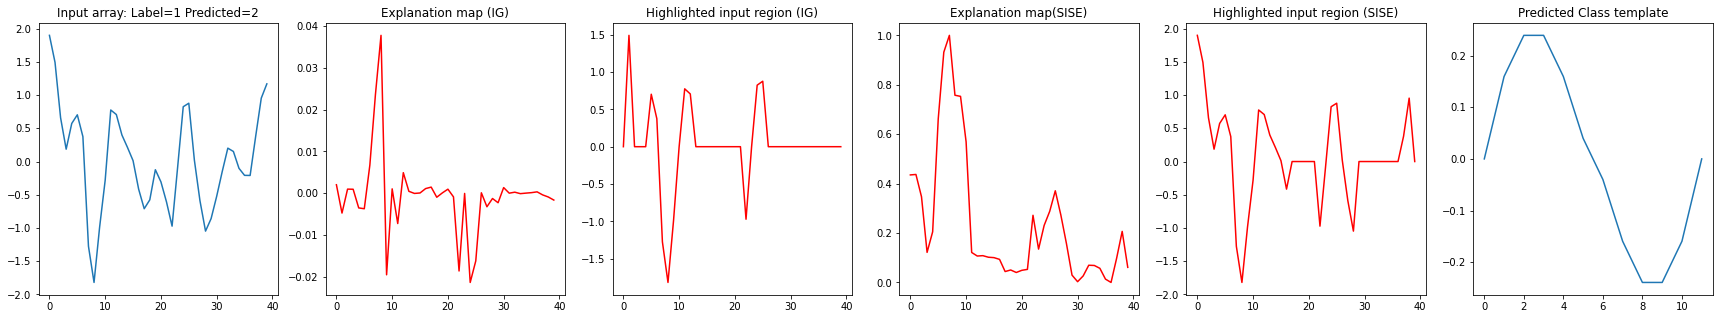

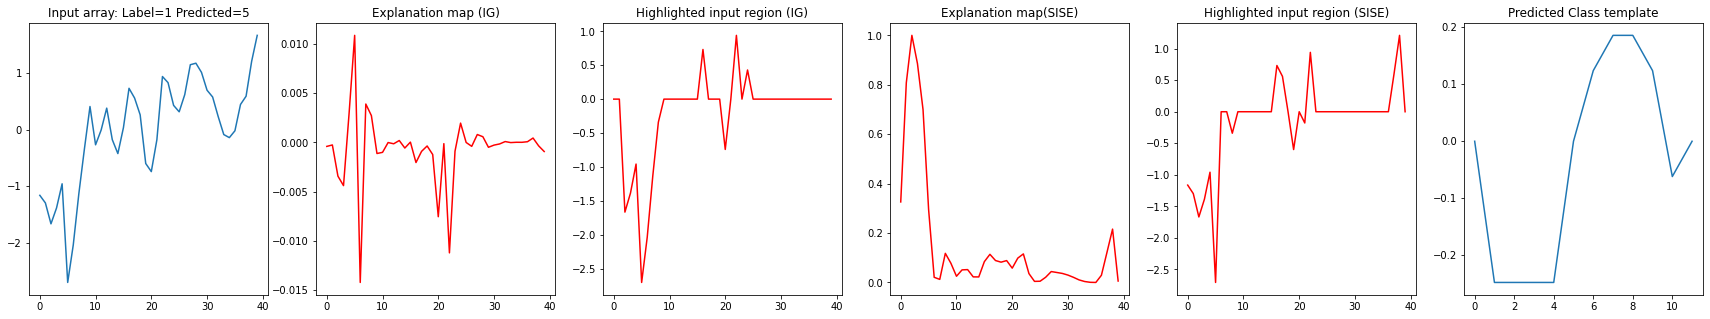

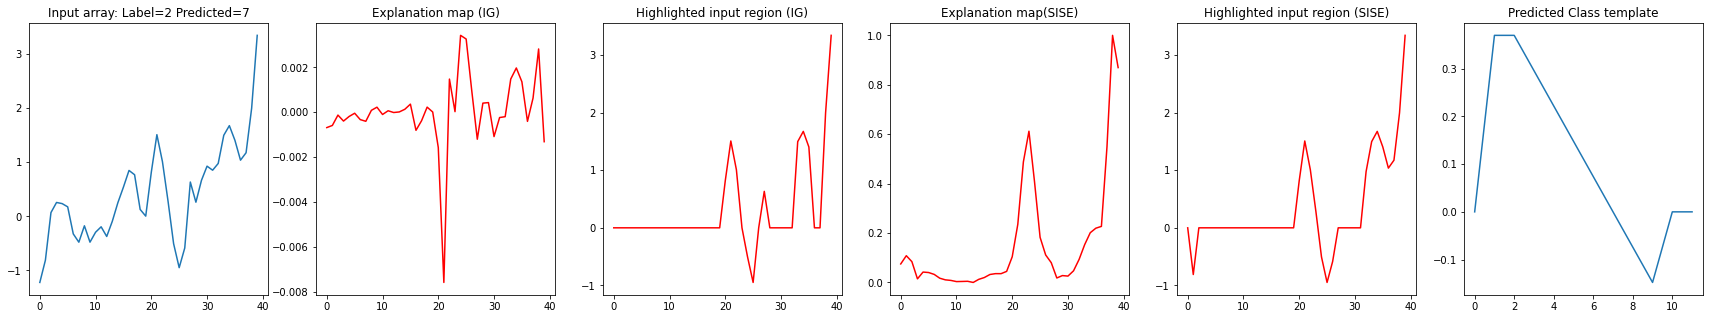

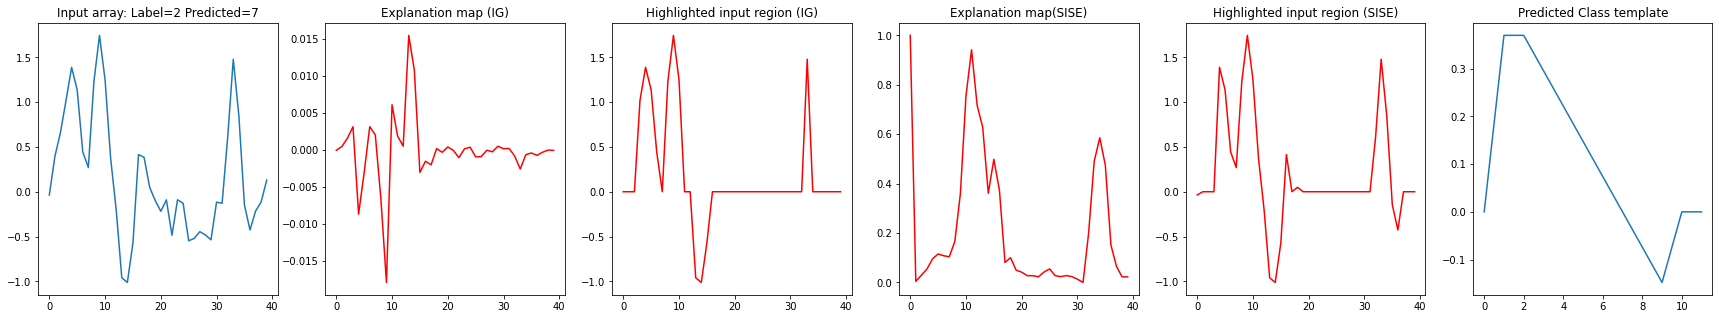

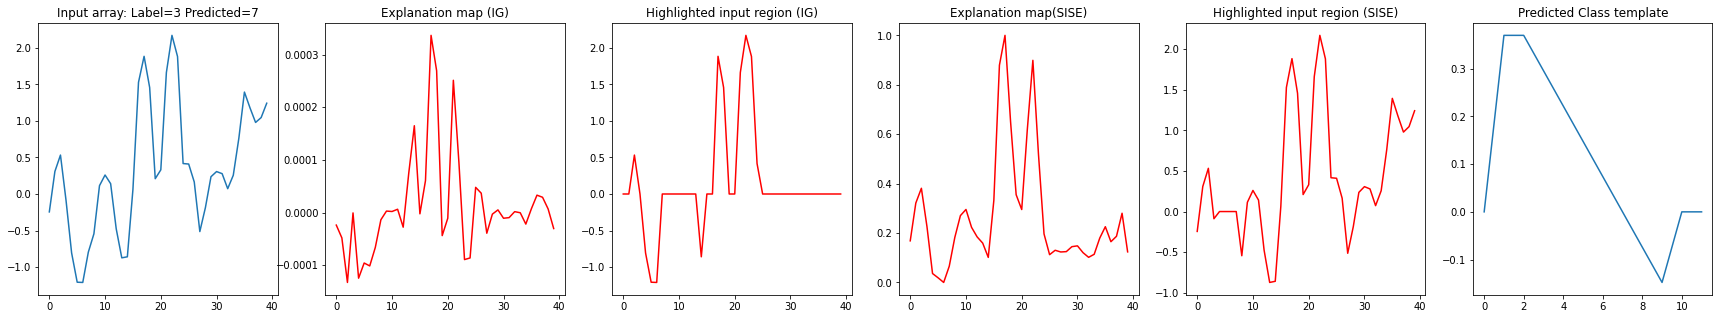

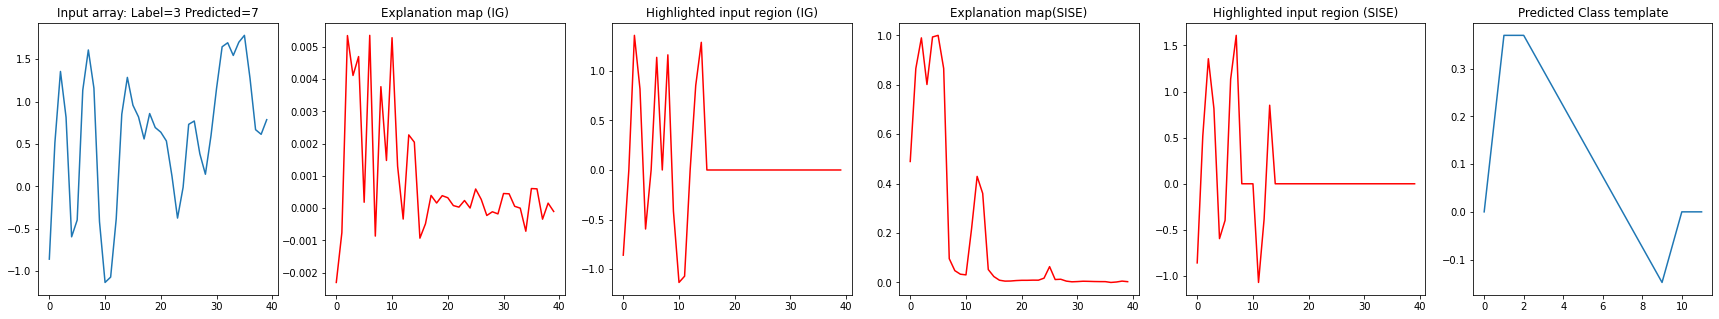

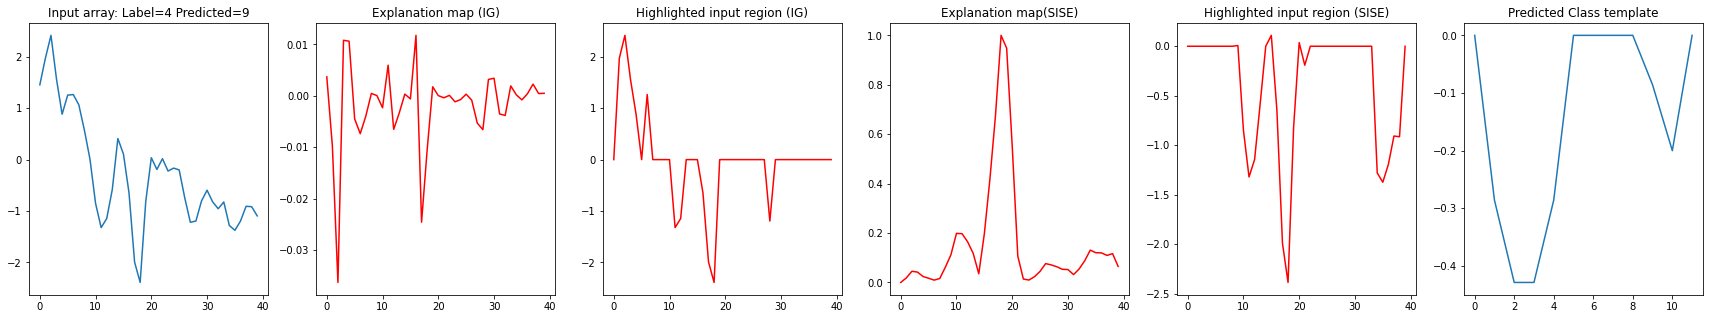

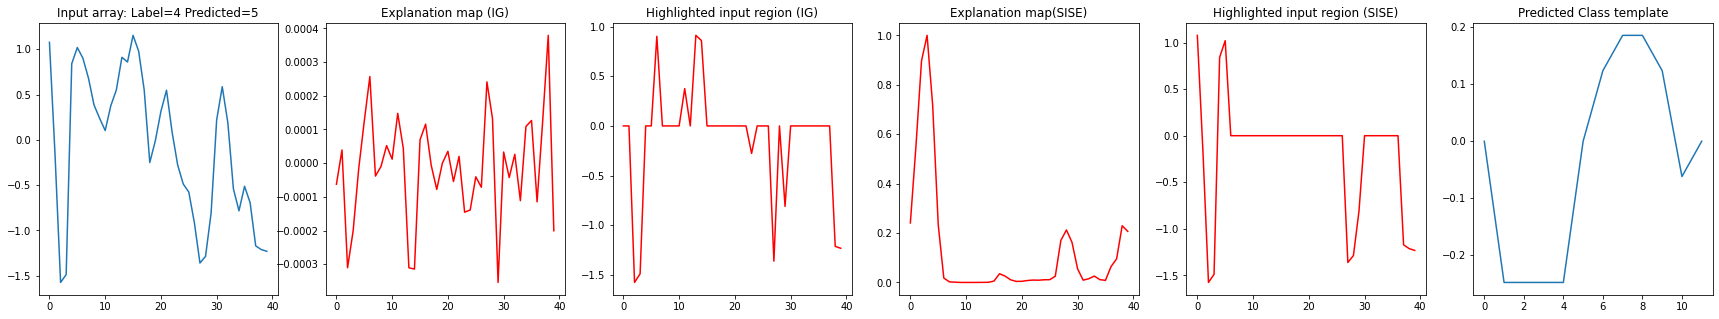

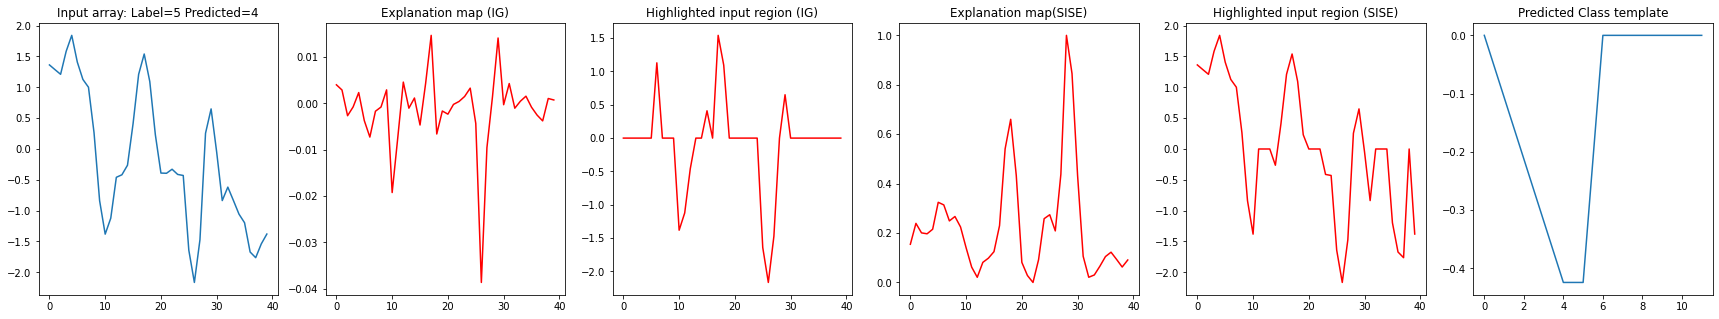

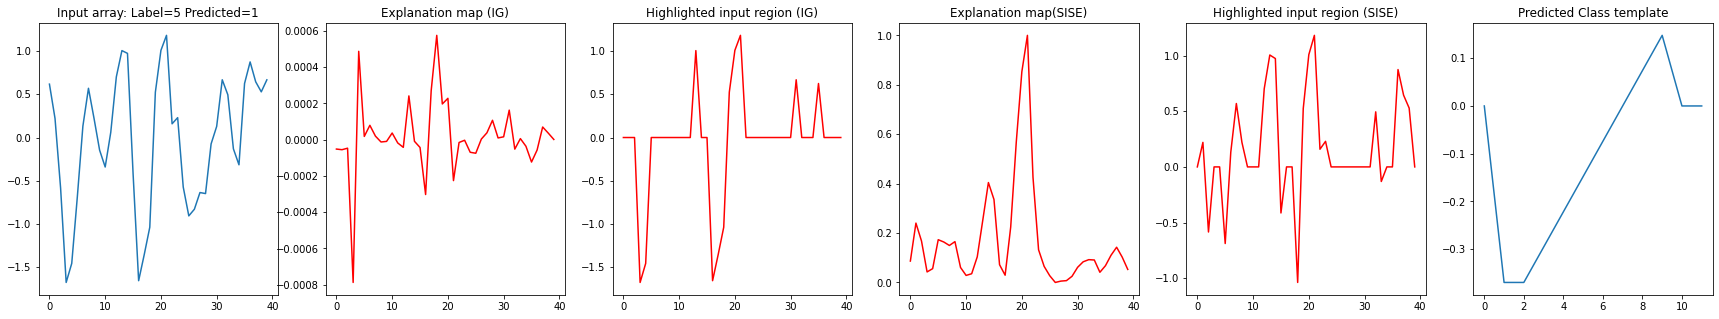

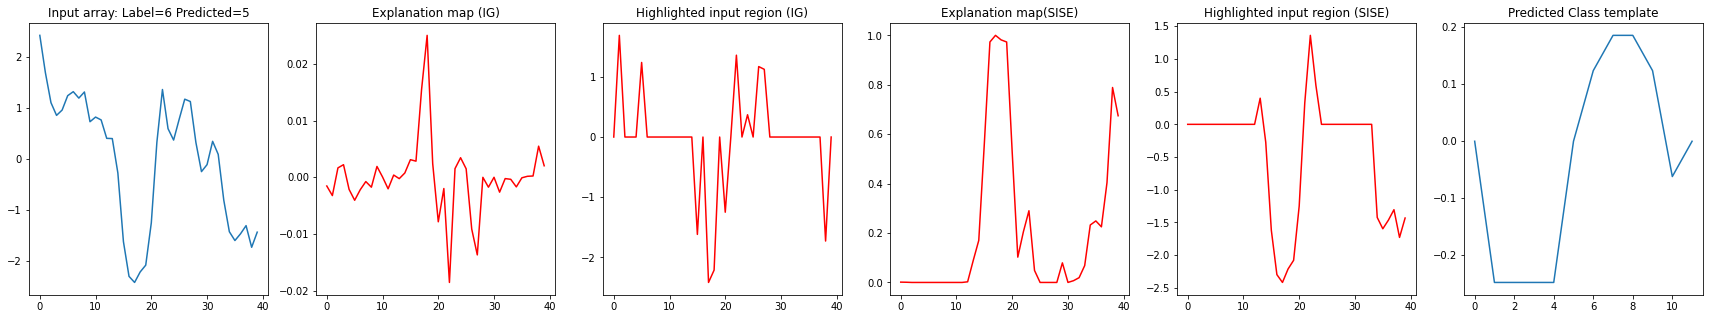

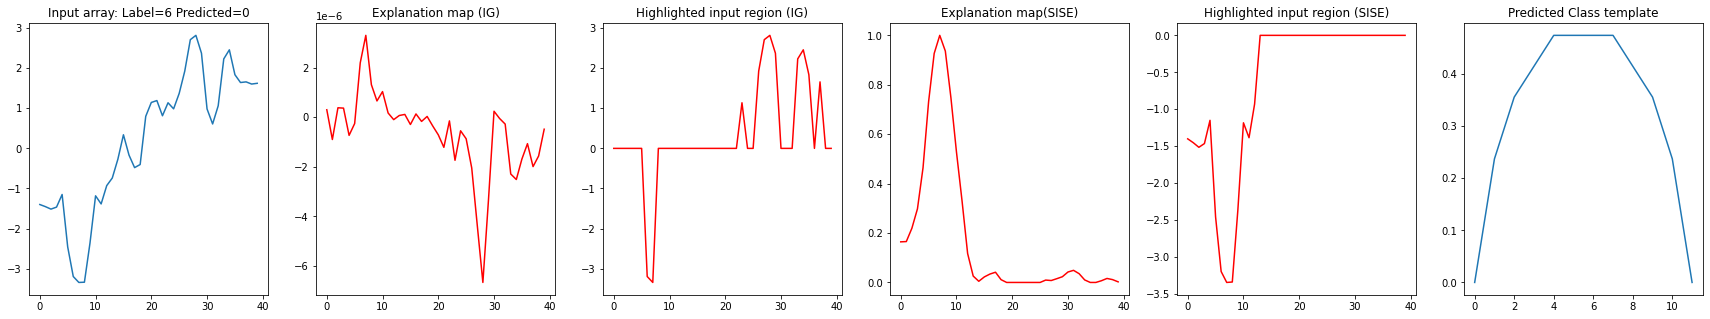

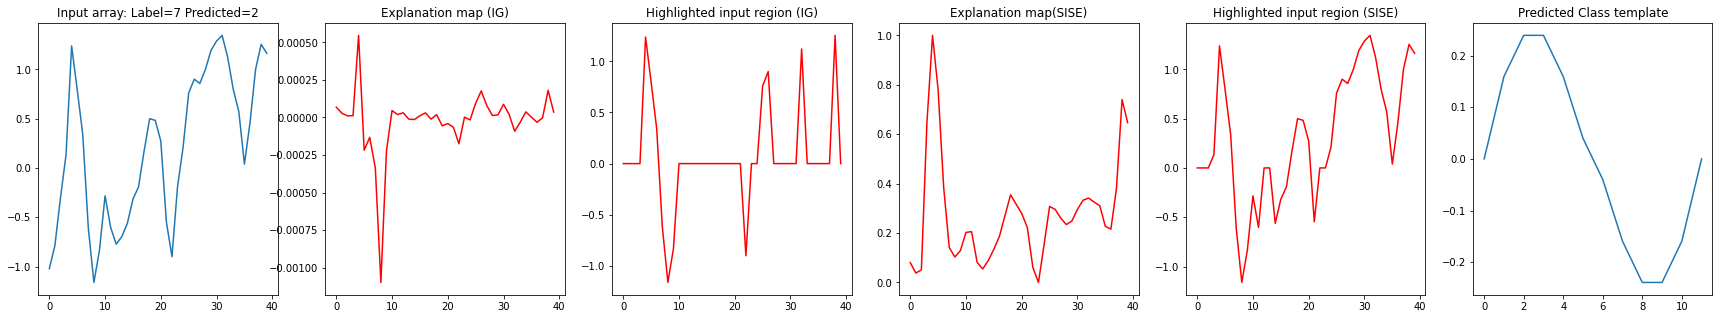

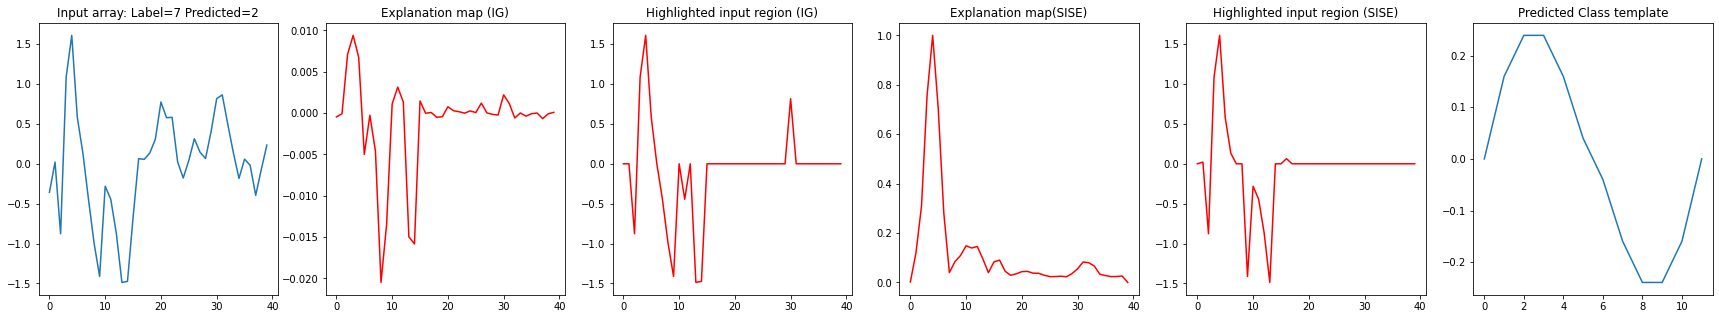

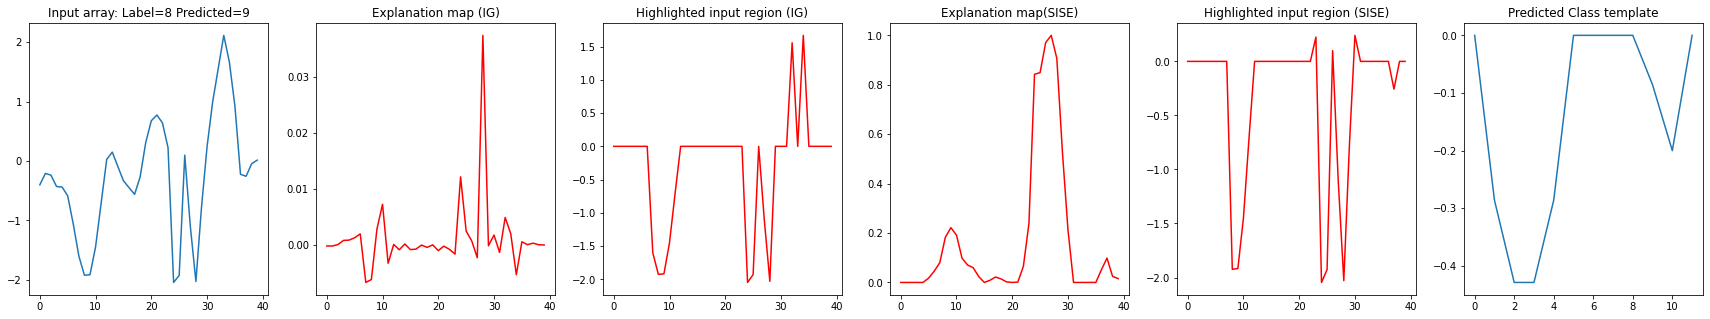

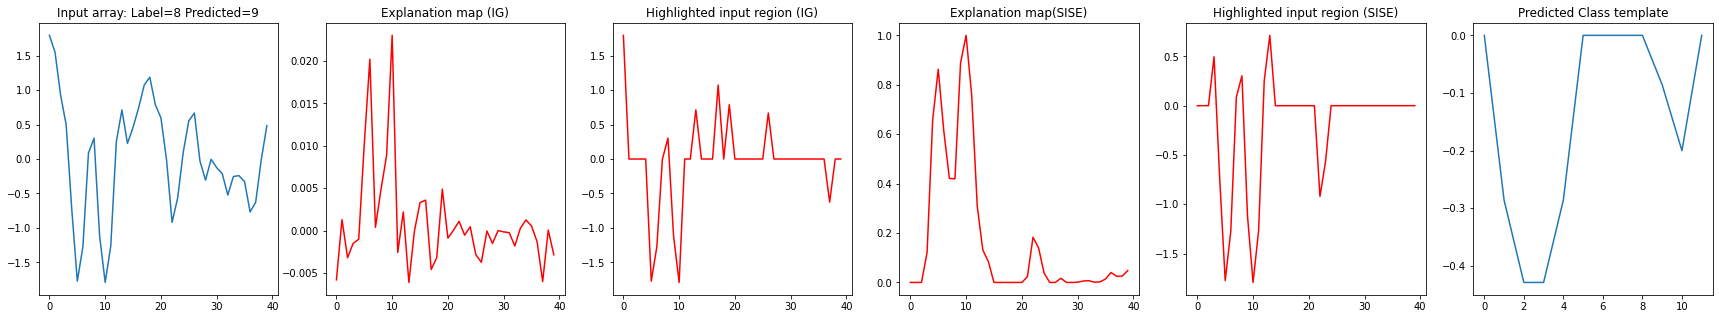

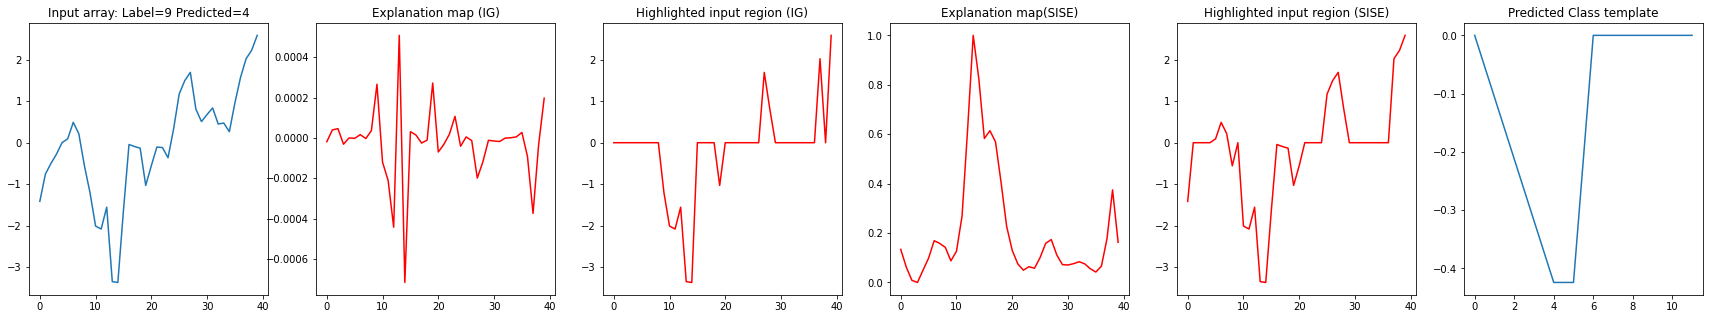

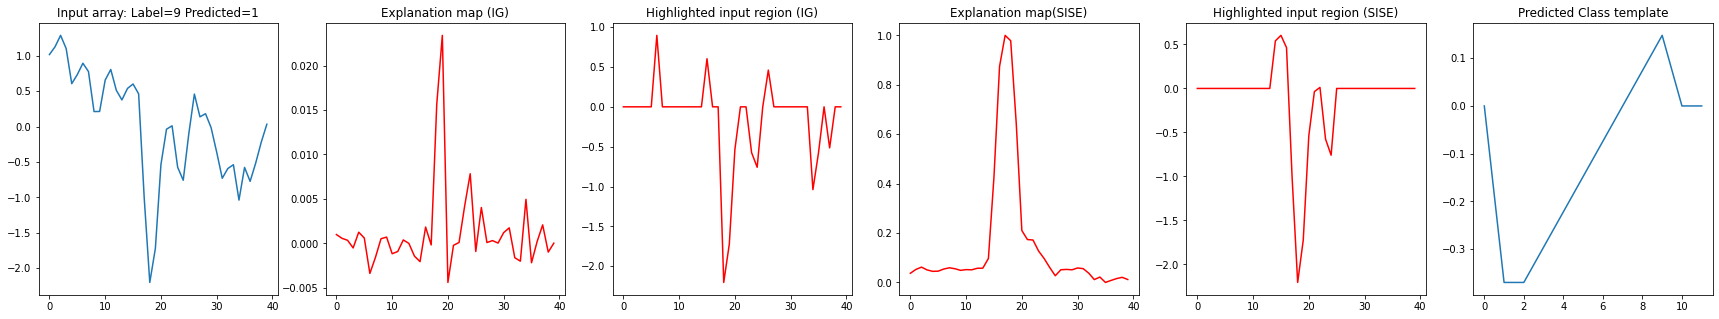

In [27]:
for i in range(10):
  for j in range(2):
    index = plotted_index_failed[i][j]
    input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
    label = y_test[index]
    predicted = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)))

    num_plots = 6
    plt.figure(figsize=(5*num_plots,5))
    plt.subplot(1,num_plots,1)
    plt.plot(input[0])
    plt.title('Input array: Label=%d Predicted=%d'%(label,predicted))
    explanation_IG = Integrated_Gradients(input, model, label, 100)
    threshold_IG = np.sort(np.absolute(explanation_IG[:,0]))[-12]

    plt.subplot(1,num_plots,2)
    plt.plot(explanation_IG, 'r')
    plt.title('Explanation map (IG)')

    plt.subplot(1,num_plots,3)
    plt.plot((input[0]*(np.absolute(explanation_IG)>threshold_IG)), 'r')
    plt.title('Highlighted input region (IG)')


    explanation_SISE = SISE(input, model, label, [['conv1d_2']], grad_thr=0.)
    threshold_SISE = np.sort(explanation[:,0])[-12]
    
    plt.subplot(1,num_plots,4)
    plt.plot(explanation_SISE, 'r')
    plt.title('Explanation map(SISE)')

    plt.subplot(1,num_plots,5)
    plt.plot((input[0]*(explanation_SISE>threshold_SISE)), 'r')
    plt.title('Highlighted input region (SISE)')

    plt.subplot(1,num_plots,6)
    plt.plot(dataset['templates']['x'][predicted])
    plt.title('Predicted Class template')
    plt.show()

## Quantitative evaluation

In [31]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.3):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(np.absolute(grad_array)))[array_size]
    exmap1_msk=(np.absolute(exmap)>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

###SISE

In [18]:
#SISE drop rate
drop_rate = 0.
increase_rate = 0.
for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    explanation_map = SISE(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, layers=[['conv1d_2']], class_index=np.argmax(prediction[0]), grad_thr=0.)
    drop_increase = calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]))
    drop_rate += drop_increase[0]
    if (drop_increase[1] == 1):
      increase_rate += 1
drop_rate /= 1000
increase_rate /= 1000

SISE_drop_increase = (drop_rate, increase_rate)

In [19]:
print(SISE_drop_increase)

(0.12825230493689818, 0.473)


### IG

In [20]:
drop_rate = 0.
increase_rate = 0.
for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    explanation_map = Integrated_Gradients(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, np.argmax(prediction[0]), 50)
    drop_increase = calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]))
    drop_rate += drop_increase[0]
    if (drop_increase[1] == 1):
      increase_rate += 1
drop_rate /= 1000
increase_rate /= 1000

IG_drop_increase = (drop_rate, increase_rate)

In [21]:
print(IG_drop_increase)

(0.3725009357992292, 0.233)


### IG without multiplying by the original image

In [29]:
def get_gradients(input, model, pred_index):
  image = tensorflow.convert_to_tensor(input)
  with tensorflow.GradientTape() as tape:
    tape.watch(image)
    prediction=model(image)
    gradient = tape.gradient(prediction[0][pred_index],image)
  return gradient

def Integrated_Gradients(input, model, label, num_steps):
  baseline = np.zeros(input.shape)
  grads = np.zeros((40,1))
  for i in range(num_steps):
    difference = (i+1/num_steps) * (input - baseline)
    grads = grads + get_gradients(difference, model, label).numpy()[0] / num_steps
  return grads

In [32]:
drop_rate = 0.
increase_rate = 0.
for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    explanation_map = Integrated_Gradients(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, np.argmax(prediction[0]), 50)
    drop_increase = calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]))
    drop_rate += drop_increase[0]
    if (drop_increase[1] == 1):
      increase_rate += 1
drop_rate /= 1000
increase_rate /= 1000

IG_drop_increase_grad_only = (drop_rate, increase_rate)

In [34]:
#Much worse
IG_drop_increase_grad_only

(0.5421303906499227, 0.161)